In [1]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import font_manager, rc
import platform
from sklearn import preprocessing
import re

if platform.system() == 'Darwin':
    rc('font', family = 'AppleGothic')
elif platform.system() == 'Windows':
    font_name = font_manager.FontProperties(fname = 'c:/Windows/Fonts/malgun.ttf').get_name()
    rc('font', family=font_name)

## 요일, 시간 전처리

In [2]:
# data 로드
vod = pd.read_csv('vod_prepro_series_nm.csv')
con = pd.read_csv('con_prepro_series_nm.csv', encoding='cp949')

In [3]:
vod.rename(columns={'strt_dt':'log_dt'}, inplace=True)
vod['log_dt'] = pd.to_datetime(vod['log_dt'], format='%Y%m%d%H%M%S')
vod.drop_duplicates(inplace=True)
vod[vod.duplicated()]
vod

,subsr,asset_nm,ct_cl,genre_of_ct_cl,use_tms,SMRY,ACTR_DISP,disp_rtm,log_dt,Category,rename,vod_id
0,65941000,그것이알고싶다,TV 시사/교양,기타,80.0,살인자의 자백 그리고 아크말의 고백. 방대한 수사기록과 당시 아크말의 진술을 토대로...,김상중,80,2023-08-12 16:35:07,TV프로그램,그것이알고싶다,297
1,66873000,그것이알고싶다,TV 시사/교양,기타,80.0,살인자의 자백 그리고 아크말의 고백. 방대한 수사기록과 당시 아크말의 진술을 토대로...,김상중,80,2023-08-16 20:52:27,TV프로그램,그것이알고싶다,297
2,66873000,그것이알고싶다,TV 시사/교양,기타,12.0,살인자의 자백 그리고 아크말의 고백. 방대한 수사기록과 당시 아크말의 진술을 토대로...,김상중,80,2023-08-29 19:47:27,TV프로그램,그것이알고싶다,297
3,61689000,그것이알고싶다,TV 시사/교양,기타,80.0,살인자의 자백 그리고 아크말의 고백. 방대한 수사기록과 당시 아크말의 진술을 토대로...,김상중,80,2023-08-13 13:06:09,TV프로그램,그것이알고싶다,297
4,61619000,꼬리에꼬리를무는그날이야기,TV 시사/교양,기타,69.7,"살인범의 미토콘드리아 - 2006 냉동고 살인사건. 2006년 7월 23일, 서울 ...","장도연,장현성,장성규",73,2023-08-04 09:27:37,TV프로그램,꼬리에꼬리를무는그날이야기,8
...,...,...,...,...,...,...,...,...,...,...,...,...
10156,60169000,간질간질,키즈,학습,6.0,인기작가 서현의 그림책! 온몸으로 읽는 그림책 간질간질. 글자가 형태로 보이지 않고...,-,6,2023-09-14 21:11:10,키즈,간질간질,3676
10157,66317000,알사탕,키즈,학습,8.0,"인기 작가 백희나 신간. 교보문고, YES24 베스트셀러! 상대방의 입장을 헤아리고...",-,8,2023-09-03 22:35:44,키즈,알사탕,3673
10158,66317000,알사탕,키즈,학습,3.3,"인기 작가 백희나 신간. 교보문고, YES24 베스트셀러! 상대방의 입장을 헤아리고...",-,8,2023-09-03 22:32:10,키즈,알사탕,3673
10159,66900000,월간 아기상어,키즈,학습,0.8,8-Bit Baby Shark. 오락실에 아기 상어가 나타났다?! 추억의 8비트 버...,아기상어,1,2023-09-04 12:00:57,키즈,월간아기상어,406


In [4]:
con['asset_nm'] = con['series_nm']
con.drop(['series_nm', 'super_asset_nm'], axis=1, inplace=True)
con['log_dt'] = pd.to_datetime(con['log_dt'], format='%Y%m%d%H%M%S')
con.drop_duplicates(inplace=True)
con[con.duplicated()]
con

,subsr,ct_cl,genre_of_ct_cl,SMRY,ACTR_DISP,disp_rtm,log_dt,Category,rename,vod_id,asset_nm
0,65968000,키즈,기타,"겨울잠. 숲, 바다, 극지방 등 세계 여러 곳에 사는 동물 친구들을 만나러 가자! ...",핑크퐁,1,2023-08-13 07:11:55,키즈,핑크퐁동물동요,882,핑크퐁 동물 동요
1,65968000,키즈,기타,"겨울잠. 숲, 바다, 극지방 등 세계 여러 곳에 사는 동물 친구들을 만나러 가자! ...",핑크퐁,1,2023-08-13 07:12:15,키즈,핑크퐁동물동요,882,핑크퐁 동물 동요
2,63086000,키즈,기타,로봇 세상에서 킥보드를 타요. 로보카 폴리 브룸스 타운에서 킥보드를 타요~ / 새로...,"헤이지니,럭키강이",11,2023-08-27 14:55:42,키즈,지니강이플러스시즌7,1622,지니강이 플러스 시즌7
3,63086000,키즈,기타,지니가 화장품으로 슬라임을 만들어요. / 슈퍼히어로 강이! 문을 열면 춤을 춰요.,"헤이지니,럭키강이",11,2023-08-27 15:24:17,키즈,지니강이플러스시즌9,2043,지니강이 플러스 시즌9
4,62733000,키즈,기타,미니 시리얼 팬케이크 만들기.,-,13,2023-08-16 11:28:16,키즈,엘리가간다시즌12,1958,엘리가간다 시즌12
...,...,...,...,...,...,...,...,...,...,...,...
21122,64551000,키즈,학습,"[교보문고,YES24,알라딘 베스트셀러] 경주에 진 그 토끼는 어떻게 되었을까? 내...",-,12,2023-09-30 12:16:57,키즈,슈퍼토끼,544,슈퍼 토끼
21123,64551000,키즈,학습,"[교보문고,YES24,알라딘 베스트셀러] 경주에 진 그 토끼는 어떻게 되었을까? 내...",-,12,2023-09-30 12:16:54,키즈,슈퍼토끼,544,슈퍼 토끼
21124,64551000,키즈,학습,"[교보문고,YES24,알라딘 베스트셀러] 경주에 진 그 토끼는 어떻게 되었을까? 내...",-,12,2023-09-30 12:16:56,키즈,슈퍼토끼,544,슈퍼 토끼
21125,64551000,키즈,학습,"[교보문고,YES24,알라딘 베스트셀러] 경주에 진 그 토끼는 어떻게 되었을까? 내...",-,12,2023-09-30 12:16:46,키즈,슈퍼토끼,544,슈퍼 토끼


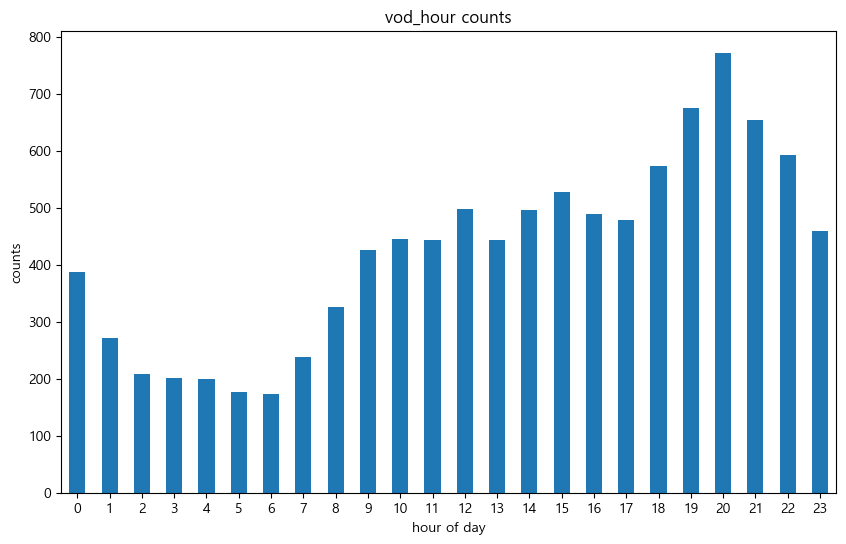

In [5]:
# 시간 추출
vod['hour'] = vod['log_dt'].dt.hour
hour_counts = vod['hour'].value_counts().sort_index()

plt.figure(figsize=(10,6))
hour_counts.plot(kind='bar')
plt.title('vod_hour counts')
plt.xlabel('hour of day')
plt.ylabel('counts')
plt.xticks(rotation=0)
plt.show()

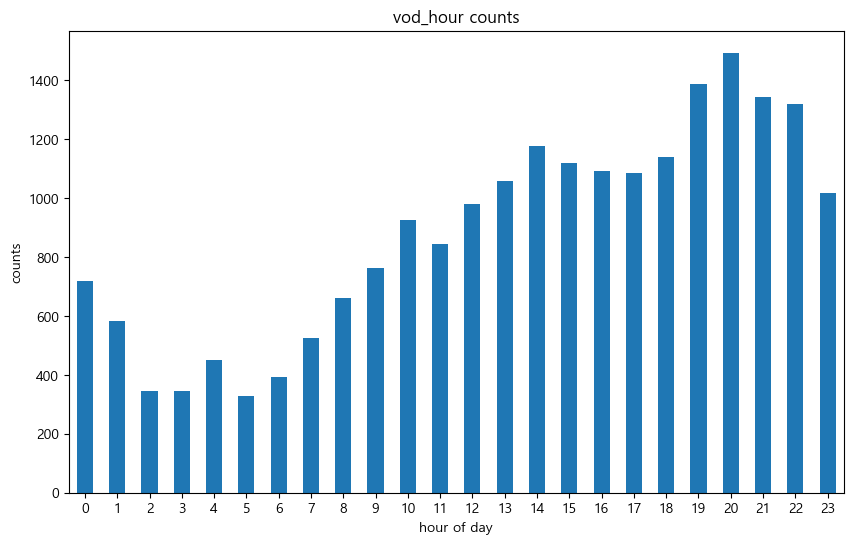

In [6]:
# 시간 추출
con['hour'] = con['log_dt'].dt.hour
con_hour_counts = con['hour'].value_counts().sort_index()

plt.figure(figsize=(10,6))
con_hour_counts.plot(kind='bar')
plt.title('vod_hour counts')
plt.xlabel('hour of day')
plt.ylabel('counts')
plt.xticks(rotation=0)
plt.show()

In [7]:
# api 이용하여 한국 공휴일 정보 가져옴
import requests
from urllib import parse
from bs4 import BeautifulSoup
from datetime import datetime

In [8]:
api_key_utf8 = '8rnsD4jDA580O81rnMuiKsWHB9HCb7O9MNFmEQfG6rPCfTbr0IN%2F7hl3tSBrvvaVHUaAHUDpoT2ct6Whj6Bl3g%3D%3D'
api_key_decode = '8rnsD4jDA580O81rnMuiKsWHB9HCb7O9MNFmEQfG6rPCfTbr0IN/7hl3tSBrvvaVHUaAHUDpoT2ct6Whj6Bl3g=='
solYear = 2023

url_holiday = f'http://apis.data.go.kr/B090041/openapi/service/SpcdeInfoService/getRestDeInfo?solYear={solYear}&ServiceKey={api_key_decode}&numOfRows=100'

response = requests.get(url_holiday)
xml = BeautifulSoup(response.text, 'lxml')
xml

C:\Users\USER\anaconda3\lib\site-packages\bs4\builder\__init__.py:545: XMLParsedAsHTMLWarning: It looks like you're parsing an XML document using an HTML parser. If this really is an HTML document (maybe it's XHTML?), you can ignore or filter this warning. If it's XML, you should know that using an XML parser will be more reliable. To parse this document as XML, make sure you have the lxml package installed, and pass the keyword argument `features="xml"` into the BeautifulSoup constructor.
  warnings.warn(


<?xml version="1.0" encoding="UTF-8" standalone="yes"?><html><body><response><header><resultcode>00</resultcode><resultmsg>NORMAL SERVICE.</resultmsg></header><items><item><datekind>01</datekind><datename>1월1일</datename><isholiday>Y</isholiday><locdate>20230101</locdate><seq>1</seq></item><item><datekind>01</datekind><datename>설날</datename><isholiday>Y</isholiday><locdate>20230121</locdate><seq>1</seq></item><item><datekind>01</datekind><datename>설날</datename><isholiday>Y</isholiday><locdate>20230122</locdate><seq>1</seq></item><item><datekind>01</datekind><datename>설날</datename><isholiday>Y</isholiday><locdate>20230123</locdate><seq>1</seq></item><item><datekind>01</datekind><datename>대체공휴일</datename><isholiday>Y</isholiday><locdate>20230124</locdate><seq>1</seq></item><item><datekind>01</datekind><datename>삼일절</datename><isholiday>Y</isholiday><locdate>20230301</locdate><seq>1</seq></item><item><datekind>01</datekind><datename>어린이날</datename><isholiday>Y</isholiday><locdate>20230505<

In [9]:
items = xml.find('items')
items

<items><item><datekind>01</datekind><datename>1월1일</datename><isholiday>Y</isholiday><locdate>20230101</locdate><seq>1</seq></item><item><datekind>01</datekind><datename>설날</datename><isholiday>Y</isholiday><locdate>20230121</locdate><seq>1</seq></item><item><datekind>01</datekind><datename>설날</datename><isholiday>Y</isholiday><locdate>20230122</locdate><seq>1</seq></item><item><datekind>01</datekind><datename>설날</datename><isholiday>Y</isholiday><locdate>20230123</locdate><seq>1</seq></item><item><datekind>01</datekind><datename>대체공휴일</datename><isholiday>Y</isholiday><locdate>20230124</locdate><seq>1</seq></item><item><datekind>01</datekind><datename>삼일절</datename><isholiday>Y</isholiday><locdate>20230301</locdate><seq>1</seq></item><item><datekind>01</datekind><datename>어린이날</datename><isholiday>Y</isholiday><locdate>20230505</locdate><seq>1</seq></item><item><datekind>01</datekind><datename>부처님오신날</datename><isholiday>Y</isholiday><locdate>20230527</locdate><seq>1</seq></item><item

In [10]:
holidays = []
for item in items:
    date = datetime.strptime(item.find('locdate').text.strip(), '%Y%m%d')
    holidays.append(pd.to_datetime(date.strftime('%Y-%m-%d')))

In [11]:
def classify_date(row):
    if row in holidays or row.weekday() >=5:
        return 1
    else:
        return 0

In [12]:
# YYYY-MM-DD 열 만들기
vod['today'] = pd.to_datetime(vod['log_dt'].dt.date)
con['today'] = pd.to_datetime(con['log_dt'].dt.date)
vod.info()
con.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10161 entries, 0 to 10160
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   subsr           10161 non-null  int64         
 1   asset_nm        10161 non-null  object        
 2   ct_cl           10161 non-null  object        
 3   genre_of_ct_cl  10161 non-null  object        
 4   use_tms         10161 non-null  float64       
 5   SMRY            10157 non-null  object        
 6   ACTR_DISP       10157 non-null  object        
 7   disp_rtm        10161 non-null  int64         
 8   log_dt          10161 non-null  datetime64[ns]
 9   Category        10161 non-null  object        
 10  rename          10161 non-null  object        
 11  vod_id          10161 non-null  int64         
 12  hour            10161 non-null  int32         
 13  today           10161 non-null  datetime64[ns]
dtypes: datetime64[ns](2), float64(1), int32(1), int64(3), 

In [13]:
vod['today_type'] = vod['today'].apply(classify_date)
vod['tomorrow'] = vod['today'].apply(lambda x: x + pd.DateOffset(days=1))
vod['tomorrow_type'] = vod['tomorrow'].apply(classify_date)
vod['yesterday'] = vod['today'].apply(lambda x: x + pd.DateOffset(days=-1))
vod['yesterday_type'] = vod['yesterday'].apply(classify_date)
vod

,subsr,asset_nm,ct_cl,genre_of_ct_cl,use_tms,SMRY,ACTR_DISP,disp_rtm,log_dt,Category,rename,vod_id,hour,today,today_type,tomorrow,tomorrow_type,yesterday,yesterday_type
0,65941000,그것이알고싶다,TV 시사/교양,기타,80.0,살인자의 자백 그리고 아크말의 고백. 방대한 수사기록과 당시 아크말의 진술을 토대로...,김상중,80,2023-08-12 16:35:07,TV프로그램,그것이알고싶다,297,16,2023-08-12,1,2023-08-13,1,2023-08-11,0
1,66873000,그것이알고싶다,TV 시사/교양,기타,80.0,살인자의 자백 그리고 아크말의 고백. 방대한 수사기록과 당시 아크말의 진술을 토대로...,김상중,80,2023-08-16 20:52:27,TV프로그램,그것이알고싶다,297,20,2023-08-16,0,2023-08-17,0,2023-08-15,1
2,66873000,그것이알고싶다,TV 시사/교양,기타,12.0,살인자의 자백 그리고 아크말의 고백. 방대한 수사기록과 당시 아크말의 진술을 토대로...,김상중,80,2023-08-29 19:47:27,TV프로그램,그것이알고싶다,297,19,2023-08-29,0,2023-08-30,0,2023-08-28,0
3,61689000,그것이알고싶다,TV 시사/교양,기타,80.0,살인자의 자백 그리고 아크말의 고백. 방대한 수사기록과 당시 아크말의 진술을 토대로...,김상중,80,2023-08-13 13:06:09,TV프로그램,그것이알고싶다,297,13,2023-08-13,1,2023-08-14,0,2023-08-12,1
4,61619000,꼬리에꼬리를무는그날이야기,TV 시사/교양,기타,69.7,"살인범의 미토콘드리아 - 2006 냉동고 살인사건. 2006년 7월 23일, 서울 ...","장도연,장현성,장성규",73,2023-08-04 09:27:37,TV프로그램,꼬리에꼬리를무는그날이야기,8,9,2023-08-04,0,2023-08-05,1,2023-08-03,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10156,60169000,간질간질,키즈,학습,6.0,인기작가 서현의 그림책! 온몸으로 읽는 그림책 간질간질. 글자가 형태로 보이지 않고...,-,6,2023-09-14 21:11:10,키즈,간질간질,3676,21,2023-09-14,0,2023-09-15,0,2023-09-13,0
10157,66317000,알사탕,키즈,학습,8.0,"인기 작가 백희나 신간. 교보문고, YES24 베스트셀러! 상대방의 입장을 헤아리고...",-,8,2023-09-03 22:35:44,키즈,알사탕,3673,22,2023-09-03,1,2023-09-04,0,2023-09-02,1
10158,66317000,알사탕,키즈,학습,3.3,"인기 작가 백희나 신간. 교보문고, YES24 베스트셀러! 상대방의 입장을 헤아리고...",-,8,2023-09-03 22:32:10,키즈,알사탕,3673,22,2023-09-03,1,2023-09-04,0,2023-09-02,1
10159,66900000,월간 아기상어,키즈,학습,0.8,8-Bit Baby Shark. 오락실에 아기 상어가 나타났다?! 추억의 8비트 버...,아기상어,1,2023-09-04 12:00:57,키즈,월간아기상어,406,12,2023-09-04,0,2023-09-05,0,2023-09-03,1


In [14]:
con['today_type'] = con['today'].apply(classify_date)
con['tomorrow'] = con['today'].apply(lambda x: x + pd.DateOffset(days=1))
con['tomorrow_type'] = con['tomorrow'].apply(classify_date)
con['yesterday'] = con['today'].apply(lambda x: x + pd.DateOffset(days=-1))
con['yesterday_type'] = con['yesterday'].apply(classify_date)
con

,subsr,ct_cl,genre_of_ct_cl,SMRY,ACTR_DISP,disp_rtm,log_dt,Category,rename,vod_id,asset_nm,hour,today,today_type,tomorrow,tomorrow_type,yesterday,yesterday_type
0,65968000,키즈,기타,"겨울잠. 숲, 바다, 극지방 등 세계 여러 곳에 사는 동물 친구들을 만나러 가자! ...",핑크퐁,1,2023-08-13 07:11:55,키즈,핑크퐁동물동요,882,핑크퐁 동물 동요,7,2023-08-13,1,2023-08-14,0,2023-08-12,1
1,65968000,키즈,기타,"겨울잠. 숲, 바다, 극지방 등 세계 여러 곳에 사는 동물 친구들을 만나러 가자! ...",핑크퐁,1,2023-08-13 07:12:15,키즈,핑크퐁동물동요,882,핑크퐁 동물 동요,7,2023-08-13,1,2023-08-14,0,2023-08-12,1
2,63086000,키즈,기타,로봇 세상에서 킥보드를 타요. 로보카 폴리 브룸스 타운에서 킥보드를 타요~ / 새로...,"헤이지니,럭키강이",11,2023-08-27 14:55:42,키즈,지니강이플러스시즌7,1622,지니강이 플러스 시즌7,14,2023-08-27,1,2023-08-28,0,2023-08-26,1
3,63086000,키즈,기타,지니가 화장품으로 슬라임을 만들어요. / 슈퍼히어로 강이! 문을 열면 춤을 춰요.,"헤이지니,럭키강이",11,2023-08-27 15:24:17,키즈,지니강이플러스시즌9,2043,지니강이 플러스 시즌9,15,2023-08-27,1,2023-08-28,0,2023-08-26,1
4,62733000,키즈,기타,미니 시리얼 팬케이크 만들기.,-,13,2023-08-16 11:28:16,키즈,엘리가간다시즌12,1958,엘리가간다 시즌12,11,2023-08-16,0,2023-08-17,0,2023-08-15,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21122,64551000,키즈,학습,"[교보문고,YES24,알라딘 베스트셀러] 경주에 진 그 토끼는 어떻게 되었을까? 내...",-,12,2023-09-30 12:16:57,키즈,슈퍼토끼,544,슈퍼 토끼,12,2023-09-30,1,2023-10-01,1,2023-09-29,1
21123,64551000,키즈,학습,"[교보문고,YES24,알라딘 베스트셀러] 경주에 진 그 토끼는 어떻게 되었을까? 내...",-,12,2023-09-30 12:16:54,키즈,슈퍼토끼,544,슈퍼 토끼,12,2023-09-30,1,2023-10-01,1,2023-09-29,1
21124,64551000,키즈,학습,"[교보문고,YES24,알라딘 베스트셀러] 경주에 진 그 토끼는 어떻게 되었을까? 내...",-,12,2023-09-30 12:16:56,키즈,슈퍼토끼,544,슈퍼 토끼,12,2023-09-30,1,2023-10-01,1,2023-09-29,1
21125,64551000,키즈,학습,"[교보문고,YES24,알라딘 베스트셀러] 경주에 진 그 토끼는 어떻게 되었을까? 내...",-,12,2023-09-30 12:16:46,키즈,슈퍼토끼,544,슈퍼 토끼,12,2023-09-30,1,2023-10-01,1,2023-09-29,1


## vod, con 파일별 시청률 비교

### vod

In [15]:
# vod 평일 저녁, 휴일 저녁 비교
for today in [0, 1]:
    subset = vod[(vod['today_type'] == today)]
    subset_day = subset[(subset['hour'] >=18) & (subset['hour'] <= 23)]
    print('오늘', today, '저녁', subset_day['ct_cl'].value_counts(normalize=True)*100)
    print()

오늘 0 저녁 ct_cl
TV드라마       37.874551
TV 연예/오락    25.529365
영화          19.256892
TV 시사/교양     7.231322
키즈           7.031562
TV애니메이션      3.036356
다큐           0.039952
Name: proportion, dtype: float64

오늘 1 저녁 ct_cl
TV드라마       34.204082
TV 연예/오락    25.142857
영화          22.204082
TV 시사/교양     8.163265
키즈           7.510204
TV애니메이션      2.040816
다큐           0.653061
우리동네         0.081633
Name: proportion, dtype: float64



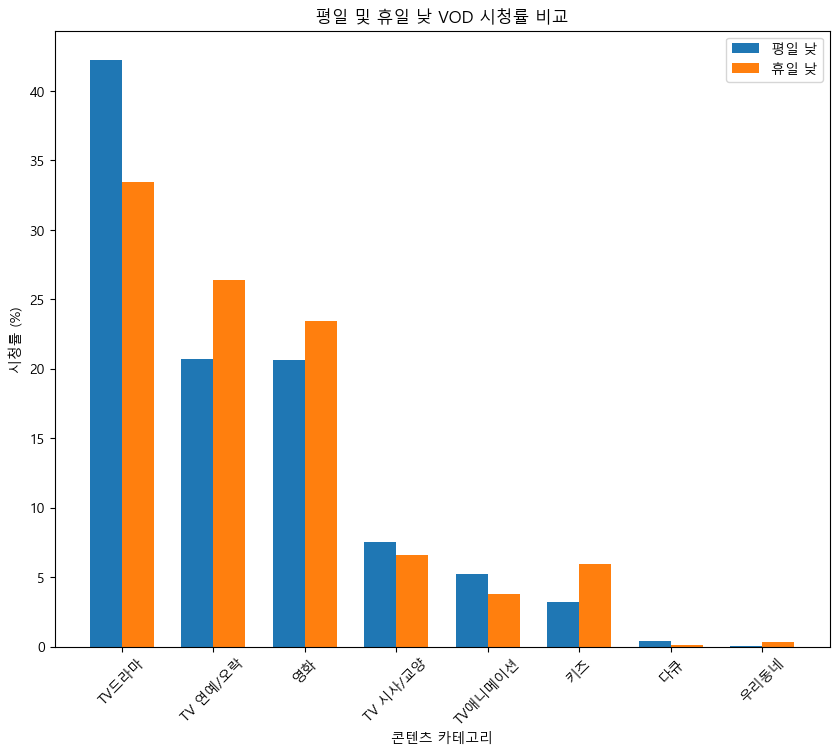

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

# 평일 저녁 데이터
weekday_evening = vod[(vod['today_type'] == 0) & (vod['hour'] >= 8) & (vod['hour'] <= 17)]['ct_cl'].value_counts(normalize=True) * 100
# 주어진 Series를 DataFrame으로 변환
weekday_evening_df = weekday_evening.reset_index()
# 열 이름 변경
weekday_evening_df.columns = ['ct_cl', '평일 낮']
# 인덱스 설정
weekday_evening_df.set_index('ct_cl', inplace=True)

# 열 이름을 transpose하여 원하는 형식으로 변경
weekday_evening_df = weekday_evening_df.transpose()

# 휴일 저녁 데이터
holiday_evening = vod[(vod['today_type'] == 1) & (vod['hour'] >= 8) & (vod['hour'] <= 17)]['ct_cl'].value_counts(normalize=True) * 100

# 주어진 Series를 DataFrame으로 변환
holiday_evening_df = holiday_evening.reset_index()
# 열 이름 변경
holiday_evening_df.columns = ['ct_cl', '휴일 낮']
# 인덱스 설정
holiday_evening_df.set_index('ct_cl', inplace=True)

# 열 이름을 transpose하여 원하는 형식으로 변경
holiday_evening_df = holiday_evening_df.transpose()

data = pd.concat([weekday_evening_df, holiday_evening_df], axis=0)
data

bar_width = 0.35
index = np.arange(len(data.columns))

# Creating a plot
fig, ax = plt.subplots(figsize=(10, 8))

# Plotting bars for each category
bars1 = ax.bar(index, data.loc["평일 낮"], bar_width, label="평일 낮")
bars2 = ax.bar(index + bar_width, data.loc["휴일 낮"], bar_width, label="휴일 낮")

# Adding labels and title
ax.set_xlabel('콘텐츠 카테고리')
ax.set_ylabel('시청률 (%)')
ax.set_title('평일 및 휴일 낮 VOD 시청률 비교')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(data.columns)
ax.legend()

# Show plot
plt.xticks(rotation=45)
plt.show()

In [17]:
# 평일일 때 다음날과 결합 시청 비율 확인
for today in ['평일']:
    for tomorrow in ['평일', '휴일']:
        subset = vod[(vod['today_type'] == today) & (vod['tomorrow_type'] == tomorrow)]
        subset_dawn = subset[subset['hour'] <= 7]
        print('오늘', today, '다음날', tomorrow, '새벽', subset_dawn['ct_cl'].value_counts(normalize=True)*100)
        print()
        subset_day = subset[(subset['hour'] >=8) & (subset['hour'] <= 17)]
        print('오늘', today, '다음날', tomorrow, '낮', subset_day['ct_cl'].value_counts(normalize=True)*100)
        print()
        subset_night = subset[(subset['hour'] >=18) & (subset['hour'] <= 23)]
        print('오늘', today, '다음날', tomorrow, '저녁', subset_night['ct_cl'].value_counts(normalize=True)*100)
        print()

오늘 평일 다음날 평일 새벽 Series([], Name: proportion, dtype: float64)

오늘 평일 다음날 평일 낮 Series([], Name: proportion, dtype: float64)

오늘 평일 다음날 평일 저녁 Series([], Name: proportion, dtype: float64)

오늘 평일 다음날 휴일 새벽 Series([], Name: proportion, dtype: float64)

오늘 평일 다음날 휴일 낮 Series([], Name: proportion, dtype: float64)

오늘 평일 다음날 휴일 저녁 Series([], Name: proportion, dtype: float64)



In [18]:
# 평일일 때 전날과 결합 시청 비율 확인
for yesterday in ['평일', '휴일']:
    for today in ['평일']:
        subset = vod[(vod['yesterday_type'] == yesterday) & (vod['today_type'] == today)]
        subset_dawn = subset[subset['hour'] <= 7]
        print('전날', yesterday, '오늘', today, '새벽', subset_dawn['ct_cl'].value_counts(normalize=True)*100)
        print()
        subset_day = subset[(subset['hour'] >=8) & (subset['hour'] <= 17)]
        print('전날', yesterday, '오늘', today, '낮', subset_day['ct_cl'].value_counts(normalize=True)*100)
        print()
        subset_night = subset[(subset['hour'] >=18) & (subset['hour'] <= 23)]
        print('전날', yesterday, '오늘', today, '저녁', subset_night['ct_cl'].value_counts(normalize=True)*100)
        print()

전날 평일 오늘 평일 새벽 Series([], Name: proportion, dtype: float64)

전날 평일 오늘 평일 낮 Series([], Name: proportion, dtype: float64)

전날 평일 오늘 평일 저녁 Series([], Name: proportion, dtype: float64)

전날 휴일 오늘 평일 새벽 Series([], Name: proportion, dtype: float64)

전날 휴일 오늘 평일 낮 Series([], Name: proportion, dtype: float64)

전날 휴일 오늘 평일 저녁 Series([], Name: proportion, dtype: float64)



In [19]:
# 휴일일 때 다음날과 결합 시청 비율 확인
for today in ['휴일']:
    for tomorrow in ['평일', '휴일']:
        subset = vod[(vod['today_type'] == today) & (vod['tomorrow_type'] == tomorrow)]
        subset_dawn = subset[subset['hour'] <= 7]
        print('오늘', today, '다음날', tomorrow, '새벽', subset_dawn['ct_cl'].value_counts(normalize=True)*100)
        print()
        subset_day = subset[(subset['hour'] >=8) & (subset['hour'] <= 17)]
        print('오늘', today, '다음날', tomorrow, '낮', subset_day['ct_cl'].value_counts(normalize=True)*100)
        print()
        subset_night = subset[(subset['hour'] >=18) & (subset['hour'] <= 23)]
        print('오늘', today, '다음날', tomorrow, '저녁', subset_night['ct_cl'].value_counts(normalize=True)*100)
        print()

오늘 휴일 다음날 평일 새벽 Series([], Name: proportion, dtype: float64)

오늘 휴일 다음날 평일 낮 Series([], Name: proportion, dtype: float64)

오늘 휴일 다음날 평일 저녁 Series([], Name: proportion, dtype: float64)

오늘 휴일 다음날 휴일 새벽 Series([], Name: proportion, dtype: float64)

오늘 휴일 다음날 휴일 낮 Series([], Name: proportion, dtype: float64)

오늘 휴일 다음날 휴일 저녁 Series([], Name: proportion, dtype: float64)



In [20]:
# 휴일일 때 전날과 결합 시청 비율 확인
for yesterday in ['평일', '휴일']:
    for today in ['휴일']:
        subset = vod[(vod['yesterday_type'] == yesterday) & (vod['today_type'] == today)]
        subset_dawn = subset[subset['hour'] <= 7]
        print('전날', yesterday, '오늘', today, '새벽', subset_dawn['ct_cl'].value_counts(normalize=True)*100)
        print()
        subset_day = subset[(subset['hour'] >=8) & (subset['hour'] <= 17)]
        print('전날', yesterday, '오늘', today, '낮', subset_day['ct_cl'].value_counts(normalize=True)*100)
        print()
        subset_night = subset[(subset['hour'] >=18) & (subset['hour'] <= 23)]
        print('전날', yesterday, '오늘', today, '저녁', subset_night['ct_cl'].value_counts(normalize=True)*100)
        print()

전날 평일 오늘 휴일 새벽 Series([], Name: proportion, dtype: float64)

전날 평일 오늘 휴일 낮 Series([], Name: proportion, dtype: float64)

전날 평일 오늘 휴일 저녁 Series([], Name: proportion, dtype: float64)

전날 휴일 오늘 휴일 새벽 Series([], Name: proportion, dtype: float64)

전날 휴일 오늘 휴일 낮 Series([], Name: proportion, dtype: float64)

전날 휴일 오늘 휴일 저녁 Series([], Name: proportion, dtype: float64)



In [21]:
# 오늘의 datetype에 따른 비교
for today in ['평일', '휴일']:
    for tomorrow in ['평일']:
        subset = vod[(vod['today_type'] == today) & (vod['tomorrow_type'] == tomorrow)]
        subset_dawn = subset[subset['hour'] <= 7]
        print('오늘', today, '다음날', tomorrow, '새벽', subset_dawn['ct_cl'].value_counts(normalize=True)*100)
        print()
        subset_day = subset[(subset['hour'] >=8) & (subset['hour'] <= 17)]
        print('오늘', today, '다음날', tomorrow, '낮', subset_day['ct_cl'].value_counts(normalize=True)*100)
        print()
        subset_night = subset[(subset['hour'] >=18) & (subset['hour'] <= 23)]
        print('오늘', today, '다음날', tomorrow, '저녁', subset_night['ct_cl'].value_counts(normalize=True)*100)
        print()

오늘 평일 다음날 평일 새벽 Series([], Name: proportion, dtype: float64)

오늘 평일 다음날 평일 낮 Series([], Name: proportion, dtype: float64)

오늘 평일 다음날 평일 저녁 Series([], Name: proportion, dtype: float64)

오늘 휴일 다음날 평일 새벽 Series([], Name: proportion, dtype: float64)

오늘 휴일 다음날 평일 낮 Series([], Name: proportion, dtype: float64)

오늘 휴일 다음날 평일 저녁 Series([], Name: proportion, dtype: float64)



In [22]:
# 오늘의 datetype에 따른 비교
for today in ['평일', '휴일']:
    for tomorrow in ['휴일']:
        subset = vod[(vod['today_type'] == today) & (vod['tomorrow_type'] == tomorrow)]
        subset_dawn = subset[subset['hour'] <= 7]
        print('오늘', today, '다음날', tomorrow, '새벽', subset_dawn['ct_cl'].value_counts(normalize=True)*100)
        print()
        subset_day = subset[(subset['hour'] >=8) & (subset['hour'] <= 17)]
        print('오늘', today, '다음날', tomorrow, '낮', subset_day['ct_cl'].value_counts(normalize=True)*100)
        print()
        subset_night = subset[(subset['hour'] >=18) & (subset['hour'] <= 23)]
        print('오늘', today, '다음날', tomorrow, '저녁', subset_night['ct_cl'].value_counts(normalize=True)*100)
        print()

오늘 평일 다음날 휴일 새벽 Series([], Name: proportion, dtype: float64)

오늘 평일 다음날 휴일 낮 Series([], Name: proportion, dtype: float64)

오늘 평일 다음날 휴일 저녁 Series([], Name: proportion, dtype: float64)

오늘 휴일 다음날 휴일 새벽 Series([], Name: proportion, dtype: float64)

오늘 휴일 다음날 휴일 낮 Series([], Name: proportion, dtype: float64)

오늘 휴일 다음날 휴일 저녁 Series([], Name: proportion, dtype: float64)



In [23]:
# 오늘의 datetype에 따른 비교
for yesterday in ['평일']:
    for today in ['평일', '휴일']:
        subset = vod[(vod['yesterday_type'] == yesterday) & (vod['today_type'] == today)]
        subset_dawn = subset[subset['hour'] <= 7]
        print('전날', yesterday, '오늘', today, '새벽', subset_dawn['ct_cl'].value_counts(normalize=True)*100)
        print()
        subset_day = subset[(subset['hour'] >=8) & (subset['hour'] <= 17)]
        print('전날', yesterday, '오늘', today, '낮', subset_day['ct_cl'].value_counts(normalize=True)*100)
        print()
        subset_night = subset[(subset['hour'] >=18) & (subset['hour'] <= 23)]
        print('전날', yesterday, '오늘', today, '저녁', subset_night['ct_cl'].value_counts(normalize=True)*100)
        print()

전날 평일 오늘 평일 새벽 Series([], Name: proportion, dtype: float64)

전날 평일 오늘 평일 낮 Series([], Name: proportion, dtype: float64)

전날 평일 오늘 평일 저녁 Series([], Name: proportion, dtype: float64)

전날 평일 오늘 휴일 새벽 Series([], Name: proportion, dtype: float64)

전날 평일 오늘 휴일 낮 Series([], Name: proportion, dtype: float64)

전날 평일 오늘 휴일 저녁 Series([], Name: proportion, dtype: float64)



In [24]:
# 오늘의 datetype에 따른 비교
for yesterday in ['휴일']:
    for today in ['평일', '휴일']:
        subset = vod[(vod['yesterday_type'] == yesterday) & (vod['today_type'] == today)]
        subset_dawn = subset[subset['hour'] <= 7]
        print('전날', yesterday, '오늘', today, '새벽', subset_dawn['ct_cl'].value_counts(normalize=True)*100)
        print()
        subset_day = subset[(subset['hour'] >=8) & (subset['hour'] <= 17)]
        print('전날', yesterday, '오늘', today, '낮', subset_day['ct_cl'].value_counts(normalize=True)*100)
        print()
        subset_night = subset[(subset['hour'] >=18) & (subset['hour'] <= 23)]
        print('전날', yesterday, '오늘', today, '저녁', subset_night['ct_cl'].value_counts(normalize=True)*100)
        print()

전날 휴일 오늘 평일 새벽 Series([], Name: proportion, dtype: float64)

전날 휴일 오늘 평일 낮 Series([], Name: proportion, dtype: float64)

전날 휴일 오늘 평일 저녁 Series([], Name: proportion, dtype: float64)

전날 휴일 오늘 휴일 새벽 Series([], Name: proportion, dtype: float64)

전날 휴일 오늘 휴일 낮 Series([], Name: proportion, dtype: float64)

전날 휴일 오늘 휴일 저녁 Series([], Name: proportion, dtype: float64)



### con

In [25]:
# con 평일 낮, 휴일 낮 비교
for today in ['평일', '휴일']:
    subset = con[(con['today_type'] == today)]
    subset_day = subset[(subset['hour'] >=8) & (subset['hour'] <= 17)]
    print('오늘', today, '낮', subset_day['ct_cl'].value_counts(normalize=True)*100)
    print()

오늘 평일 낮 Series([], Name: proportion, dtype: float64)

오늘 휴일 낮 Series([], Name: proportion, dtype: float64)



In [26]:
# con 평일 새벽, 휴일 새벽 비교
for today in ['평일', '휴일']:
    subset = con[(con['today_type'] == today)]
    subset_day = subset[subset['hour'] <= 7]
    print('오늘', today, '새벽', subset_day['ct_cl'].value_counts(normalize=True)*100)
    print()

오늘 평일 새벽 Series([], Name: proportion, dtype: float64)

오늘 휴일 새벽 Series([], Name: proportion, dtype: float64)



In [27]:
# con 평일 저녁, 휴일 저녁 비교
for today in ['평일', '휴일']:
    subset = con[(con['today_type'] == today)]
    subset_day = subset[(subset['hour'] >=18) & (subset['hour'] <= 23)]
    print('오늘', today, '저녁', subset_day['ct_cl'].value_counts(normalize=True)*100)
    print()

오늘 평일 저녁 Series([], Name: proportion, dtype: float64)

오늘 휴일 저녁 Series([], Name: proportion, dtype: float64)



In [28]:
# 평일일 때 다음날과 결합 시청 비율 확인
for today in ['평일']:
    for tomorrow in ['평일', '휴일']:
        subset = con[(con['today_type'] == today) & (con['tomorrow_type'] == tomorrow)]
        subset_dawn = subset[subset['hour'] <= 7]
        print('오늘', today, '다음날', tomorrow, '새벽', subset_dawn['ct_cl'].value_counts(normalize=True)*100)
        print()
        subset_day = subset[(subset['hour'] >=8) & (subset['hour'] <= 17)]
        print('오늘', today, '다음날', tomorrow, '낮', subset_day['ct_cl'].value_counts(normalize=True)*100)
        print()
        subset_night = subset[(subset['hour'] >=18) & (subset['hour'] <= 23)]
        print('오늘', today, '다음날', tomorrow, '저녁', subset_night['ct_cl'].value_counts(normalize=True)*100)
        print()

오늘 평일 다음날 평일 새벽 Series([], Name: proportion, dtype: float64)

오늘 평일 다음날 평일 낮 Series([], Name: proportion, dtype: float64)

오늘 평일 다음날 평일 저녁 Series([], Name: proportion, dtype: float64)

오늘 평일 다음날 휴일 새벽 Series([], Name: proportion, dtype: float64)

오늘 평일 다음날 휴일 낮 Series([], Name: proportion, dtype: float64)

오늘 평일 다음날 휴일 저녁 Series([], Name: proportion, dtype: float64)



In [29]:
# 평일일 때 전날과 결합 시청 비율 확인
for yesterday in ['평일', '휴일']:
    for today in ['평일']:
        subset = con[(con['yesterday_type'] == yesterday) & (con['today_type'] == today)]
        subset_dawn = subset[subset['hour'] <= 7]
        print('전날', yesterday, '오늘', today, '새벽', subset_dawn['ct_cl'].value_counts(normalize=True)*100)
        print()
        subset_day = subset[(subset['hour'] >=8) & (subset['hour'] <= 17)]
        print('전날', yesterday, '오늘', today, '낮', subset_day['ct_cl'].value_counts(normalize=True)*100)
        print()
        subset_night = subset[(subset['hour'] >=18) & (subset['hour'] <= 23)]
        print('전날', yesterday, '오늘', today, '저녁', subset_night['ct_cl'].value_counts(normalize=True)*100)
        print()

전날 평일 오늘 평일 새벽 Series([], Name: proportion, dtype: float64)

전날 평일 오늘 평일 낮 Series([], Name: proportion, dtype: float64)

전날 평일 오늘 평일 저녁 Series([], Name: proportion, dtype: float64)

전날 휴일 오늘 평일 새벽 Series([], Name: proportion, dtype: float64)

전날 휴일 오늘 평일 낮 Series([], Name: proportion, dtype: float64)

전날 휴일 오늘 평일 저녁 Series([], Name: proportion, dtype: float64)



In [30]:
# 휴일일 때 다음날과 결합 시청 비율 확인
for today in ['휴일']:
    for tomorrow in ['평일', '휴일']:
        subset = con[(con['today_type'] == today) & (con['tomorrow_type'] == tomorrow)]
        subset_dawn = subset[subset['hour'] <= 7]
        print('오늘', today, '다음날', tomorrow, '새벽', subset_dawn['ct_cl'].value_counts(normalize=True)*100)
        print()
        subset_day = subset[(subset['hour'] >=8) & (subset['hour'] <= 17)]
        print('오늘', today, '다음날', tomorrow, '낮', subset_day['ct_cl'].value_counts(normalize=True)*100)
        print()
        subset_night = subset[(subset['hour'] >=18) & (subset['hour'] <= 23)]
        print('오늘', today, '다음날', tomorrow, '저녁', subset_night['ct_cl'].value_counts(normalize=True)*100)
        print()

오늘 휴일 다음날 평일 새벽 Series([], Name: proportion, dtype: float64)

오늘 휴일 다음날 평일 낮 Series([], Name: proportion, dtype: float64)

오늘 휴일 다음날 평일 저녁 Series([], Name: proportion, dtype: float64)

오늘 휴일 다음날 휴일 새벽 Series([], Name: proportion, dtype: float64)

오늘 휴일 다음날 휴일 낮 Series([], Name: proportion, dtype: float64)

오늘 휴일 다음날 휴일 저녁 Series([], Name: proportion, dtype: float64)



In [31]:
# 휴일일 때 전날과 결합 시청 비율 확인
for yesterday in ['평일', '휴일']:
    for today in ['휴일']:
        subset = con[(con['yesterday_type'] == yesterday) & (con['today_type'] == today)]
        subset_dawn = subset[subset['hour'] <= 7]
        print('전날', yesterday, '오늘', today, '새벽', subset_dawn['ct_cl'].value_counts(normalize=True)*100)
        print()
        subset_day = subset[(subset['hour'] >=8) & (subset['hour'] <= 17)]
        print('전날', yesterday, '오늘', today, '낮', subset_day['ct_cl'].value_counts(normalize=True)*100)
        print()
        subset_night = subset[(subset['hour'] >=18) & (subset['hour'] <= 23)]
        print('전날', yesterday, '오늘', today, '저녁', subset_night['ct_cl'].value_counts(normalize=True)*100)
        print()

전날 평일 오늘 휴일 새벽 Series([], Name: proportion, dtype: float64)

전날 평일 오늘 휴일 낮 Series([], Name: proportion, dtype: float64)

전날 평일 오늘 휴일 저녁 Series([], Name: proportion, dtype: float64)

전날 휴일 오늘 휴일 새벽 Series([], Name: proportion, dtype: float64)

전날 휴일 오늘 휴일 낮 Series([], Name: proportion, dtype: float64)

전날 휴일 오늘 휴일 저녁 Series([], Name: proportion, dtype: float64)



In [32]:
# 오늘의 datetype에 따른 비교
for today in ['평일', '휴일']:
    for tomorrow in ['평일']:
        subset = con[(con['today_type'] == today) & (con['tomorrow_type'] == tomorrow)]
        subset_dawn = subset[subset['hour'] <= 7]
        print('오늘', today, '다음날', tomorrow, '새벽', subset_dawn['ct_cl'].value_counts(normalize=True)*100)
        print()
        subset_day = subset[(subset['hour'] >=8) & (subset['hour'] <= 17)]
        print('오늘', today, '다음날', tomorrow, '낮', subset_day['ct_cl'].value_counts(normalize=True)*100)
        print()
        subset_night = subset[(subset['hour'] >=18) & (subset['hour'] <= 23)]
        print('오늘', today, '다음날', tomorrow, '저녁', subset_night['ct_cl'].value_counts(normalize=True)*100)
        print()

오늘 평일 다음날 평일 새벽 Series([], Name: proportion, dtype: float64)

오늘 평일 다음날 평일 낮 Series([], Name: proportion, dtype: float64)

오늘 평일 다음날 평일 저녁 Series([], Name: proportion, dtype: float64)

오늘 휴일 다음날 평일 새벽 Series([], Name: proportion, dtype: float64)

오늘 휴일 다음날 평일 낮 Series([], Name: proportion, dtype: float64)

오늘 휴일 다음날 평일 저녁 Series([], Name: proportion, dtype: float64)



In [33]:
# 오늘의 datetype에 따른 비교
for today in ['평일', '휴일']:
    for tomorrow in ['휴일']:
        subset = con[(con['today_type'] == today) & (con['tomorrow_type'] == tomorrow)]
        subset_dawn = subset[subset['hour'] <= 7]
        print('오늘', today, '다음날', tomorrow, '새벽', subset_dawn['ct_cl'].value_counts(normalize=True)*100)
        print()
        subset_day = subset[(subset['hour'] >=8) & (subset['hour'] <= 17)]
        print('오늘', today, '다음날', tomorrow, '낮', subset_day['ct_cl'].value_counts(normalize=True)*100)
        print()
        subset_night = subset[(subset['hour'] >=18) & (subset['hour'] <= 23)]
        print('오늘', today, '다음날', tomorrow, '저녁', subset_night['ct_cl'].value_counts(normalize=True)*100)
        print()

오늘 평일 다음날 휴일 새벽 Series([], Name: proportion, dtype: float64)

오늘 평일 다음날 휴일 낮 Series([], Name: proportion, dtype: float64)

오늘 평일 다음날 휴일 저녁 Series([], Name: proportion, dtype: float64)

오늘 휴일 다음날 휴일 새벽 Series([], Name: proportion, dtype: float64)

오늘 휴일 다음날 휴일 낮 Series([], Name: proportion, dtype: float64)

오늘 휴일 다음날 휴일 저녁 Series([], Name: proportion, dtype: float64)



In [34]:
# 오늘의 datetype에 따른 비교
for yesterday in ['평일']:
    for today in ['평일', '휴일']:
        subset = con[(con['yesterday_type'] == yesterday) & (con['today_type'] == today)]
        subset_dawn = subset[subset['hour'] <= 7]
        print('전날', yesterday, '오늘', today, '새벽', subset_dawn['ct_cl'].value_counts(normalize=True)*100)
        print()
        subset_day = subset[(subset['hour'] >=8) & (subset['hour'] <= 17)]
        print('전날', yesterday, '오늘', today, '낮', subset_day['ct_cl'].value_counts(normalize=True)*100)
        print()
        subset_night = subset[(subset['hour'] >=18) & (subset['hour'] <= 23)]
        print('전날', yesterday, '오늘', today, '저녁', subset_night['ct_cl'].value_counts(normalize=True)*100)
        print()

전날 평일 오늘 평일 새벽 Series([], Name: proportion, dtype: float64)

전날 평일 오늘 평일 낮 Series([], Name: proportion, dtype: float64)

전날 평일 오늘 평일 저녁 Series([], Name: proportion, dtype: float64)

전날 평일 오늘 휴일 새벽 Series([], Name: proportion, dtype: float64)

전날 평일 오늘 휴일 낮 Series([], Name: proportion, dtype: float64)

전날 평일 오늘 휴일 저녁 Series([], Name: proportion, dtype: float64)



In [35]:
# 오늘의 datetype에 따른 비교
for yesterday in ['휴일']:
    for today in ['평일', '휴일']:
        subset = con[(con['yesterday_type'] == yesterday) & (con['today_type'] == today)]
        subset_dawn = subset[subset['hour'] <= 7]
        print('전날', yesterday, '오늘', today, '새벽', subset_dawn['ct_cl'].value_counts(normalize=True)*100)
        print()
        subset_day = subset[(subset['hour'] >=8) & (subset['hour'] <= 17)]
        print('전날', yesterday, '오늘', today, '낮', subset_day['ct_cl'].value_counts(normalize=True)*100)
        print()
        subset_night = subset[(subset['hour'] >=18) & (subset['hour'] <= 23)]
        print('전날', yesterday, '오늘', today, '저녁', subset_night['ct_cl'].value_counts(normalize=True)*100)
        print()

전날 휴일 오늘 평일 새벽 Series([], Name: proportion, dtype: float64)

전날 휴일 오늘 평일 낮 Series([], Name: proportion, dtype: float64)

전날 휴일 오늘 평일 저녁 Series([], Name: proportion, dtype: float64)

전날 휴일 오늘 휴일 새벽 Series([], Name: proportion, dtype: float64)

전날 휴일 오늘 휴일 낮 Series([], Name: proportion, dtype: float64)

전날 휴일 오늘 휴일 저녁 Series([], Name: proportion, dtype: float64)



In [36]:
total = pd.concat([vod, con])
total

,subsr,asset_nm,ct_cl,genre_of_ct_cl,use_tms,SMRY,ACTR_DISP,disp_rtm,log_dt,Category,rename,vod_id,hour,today,today_type,tomorrow,tomorrow_type,yesterday,yesterday_type
0,65941000,그것이알고싶다,TV 시사/교양,기타,80.0,살인자의 자백 그리고 아크말의 고백. 방대한 수사기록과 당시 아크말의 진술을 토대로...,김상중,80,2023-08-12 16:35:07,TV프로그램,그것이알고싶다,297,16,2023-08-12,1,2023-08-13,1,2023-08-11,0
1,66873000,그것이알고싶다,TV 시사/교양,기타,80.0,살인자의 자백 그리고 아크말의 고백. 방대한 수사기록과 당시 아크말의 진술을 토대로...,김상중,80,2023-08-16 20:52:27,TV프로그램,그것이알고싶다,297,20,2023-08-16,0,2023-08-17,0,2023-08-15,1
2,66873000,그것이알고싶다,TV 시사/교양,기타,12.0,살인자의 자백 그리고 아크말의 고백. 방대한 수사기록과 당시 아크말의 진술을 토대로...,김상중,80,2023-08-29 19:47:27,TV프로그램,그것이알고싶다,297,19,2023-08-29,0,2023-08-30,0,2023-08-28,0
3,61689000,그것이알고싶다,TV 시사/교양,기타,80.0,살인자의 자백 그리고 아크말의 고백. 방대한 수사기록과 당시 아크말의 진술을 토대로...,김상중,80,2023-08-13 13:06:09,TV프로그램,그것이알고싶다,297,13,2023-08-13,1,2023-08-14,0,2023-08-12,1
4,61619000,꼬리에꼬리를무는그날이야기,TV 시사/교양,기타,69.7,"살인범의 미토콘드리아 - 2006 냉동고 살인사건. 2006년 7월 23일, 서울 ...","장도연,장현성,장성규",73,2023-08-04 09:27:37,TV프로그램,꼬리에꼬리를무는그날이야기,8,9,2023-08-04,0,2023-08-05,1,2023-08-03,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21122,64551000,슈퍼 토끼,키즈,학습,NaN,"[교보문고,YES24,알라딘 베스트셀러] 경주에 진 그 토끼는 어떻게 되었을까? 내...",-,12,2023-09-30 12:16:57,키즈,슈퍼토끼,544,12,2023-09-30,1,2023-10-01,1,2023-09-29,1
21123,64551000,슈퍼 토끼,키즈,학습,NaN,"[교보문고,YES24,알라딘 베스트셀러] 경주에 진 그 토끼는 어떻게 되었을까? 내...",-,12,2023-09-30 12:16:54,키즈,슈퍼토끼,544,12,2023-09-30,1,2023-10-01,1,2023-09-29,1
21124,64551000,슈퍼 토끼,키즈,학습,NaN,"[교보문고,YES24,알라딘 베스트셀러] 경주에 진 그 토끼는 어떻게 되었을까? 내...",-,12,2023-09-30 12:16:56,키즈,슈퍼토끼,544,12,2023-09-30,1,2023-10-01,1,2023-09-29,1
21125,64551000,슈퍼 토끼,키즈,학습,NaN,"[교보문고,YES24,알라딘 베스트셀러] 경주에 진 그 토끼는 어떻게 되었을까? 내...",-,12,2023-09-30 12:16:46,키즈,슈퍼토끼,544,12,2023-09-30,1,2023-10-01,1,2023-09-29,1


In [37]:
total.info()

<class 'pandas.core.frame.DataFrame'>
Index: 31266 entries, 0 to 21126
Data columns (total 19 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   subsr           31266 non-null  int64         
 1   asset_nm        31266 non-null  object        
 2   ct_cl           31266 non-null  object        
 3   genre_of_ct_cl  31266 non-null  object        
 4   use_tms         10161 non-null  float64       
 5   SMRY            31262 non-null  object        
 6   ACTR_DISP       31262 non-null  object        
 7   disp_rtm        31266 non-null  int64         
 8   log_dt          31266 non-null  datetime64[ns]
 9   Category        31266 non-null  object        
 10  rename          31266 non-null  object        
 11  vod_id          31266 non-null  int64         
 12  hour            31266 non-null  int32         
 13  today           31266 non-null  datetime64[ns]
 14  today_type      31266 non-null  int64         
 15  tomorro

### 추천

- 구간은 0\~7시, 8\~17시, 18\~23시로 나눔

- 이전날, 당일, 다음날의 datetype과 구간에 따라 추천

In [38]:
# 추천 리스트 만들기
# vod
vod['today_type'] = vod['today_type'].replace({'평일':0, '휴일':1})
vod['yesterday_type'] = vod['yesterday_type'].replace({'평일':0, '휴일':1})
vod['tomorrow_type'] = vod['tomorrow_type'].replace({'평일':0, '휴일':1})


def convert_time(time):
    if time in range(0, 8):
        return 0
    elif time in range(8, 18):
        return 1
    elif time in range(18, 24):
        return 2
    else:
        return None  # 혹은 다른 기본값
    
vod['time'] = vod['hour'].apply(convert_time)
vod

,subsr,asset_nm,ct_cl,genre_of_ct_cl,use_tms,SMRY,ACTR_DISP,disp_rtm,log_dt,Category,rename,vod_id,hour,today,today_type,tomorrow,tomorrow_type,yesterday,yesterday_type,time
0,65941000,그것이알고싶다,TV 시사/교양,기타,80.0,살인자의 자백 그리고 아크말의 고백. 방대한 수사기록과 당시 아크말의 진술을 토대로...,김상중,80,2023-08-12 16:35:07,TV프로그램,그것이알고싶다,297,16,2023-08-12,1,2023-08-13,1,2023-08-11,0,1
1,66873000,그것이알고싶다,TV 시사/교양,기타,80.0,살인자의 자백 그리고 아크말의 고백. 방대한 수사기록과 당시 아크말의 진술을 토대로...,김상중,80,2023-08-16 20:52:27,TV프로그램,그것이알고싶다,297,20,2023-08-16,0,2023-08-17,0,2023-08-15,1,2
2,66873000,그것이알고싶다,TV 시사/교양,기타,12.0,살인자의 자백 그리고 아크말의 고백. 방대한 수사기록과 당시 아크말의 진술을 토대로...,김상중,80,2023-08-29 19:47:27,TV프로그램,그것이알고싶다,297,19,2023-08-29,0,2023-08-30,0,2023-08-28,0,2
3,61689000,그것이알고싶다,TV 시사/교양,기타,80.0,살인자의 자백 그리고 아크말의 고백. 방대한 수사기록과 당시 아크말의 진술을 토대로...,김상중,80,2023-08-13 13:06:09,TV프로그램,그것이알고싶다,297,13,2023-08-13,1,2023-08-14,0,2023-08-12,1,1
4,61619000,꼬리에꼬리를무는그날이야기,TV 시사/교양,기타,69.7,"살인범의 미토콘드리아 - 2006 냉동고 살인사건. 2006년 7월 23일, 서울 ...","장도연,장현성,장성규",73,2023-08-04 09:27:37,TV프로그램,꼬리에꼬리를무는그날이야기,8,9,2023-08-04,0,2023-08-05,1,2023-08-03,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10156,60169000,간질간질,키즈,학습,6.0,인기작가 서현의 그림책! 온몸으로 읽는 그림책 간질간질. 글자가 형태로 보이지 않고...,-,6,2023-09-14 21:11:10,키즈,간질간질,3676,21,2023-09-14,0,2023-09-15,0,2023-09-13,0,2
10157,66317000,알사탕,키즈,학습,8.0,"인기 작가 백희나 신간. 교보문고, YES24 베스트셀러! 상대방의 입장을 헤아리고...",-,8,2023-09-03 22:35:44,키즈,알사탕,3673,22,2023-09-03,1,2023-09-04,0,2023-09-02,1,2
10158,66317000,알사탕,키즈,학습,3.3,"인기 작가 백희나 신간. 교보문고, YES24 베스트셀러! 상대방의 입장을 헤아리고...",-,8,2023-09-03 22:32:10,키즈,알사탕,3673,22,2023-09-03,1,2023-09-04,0,2023-09-02,1,2
10159,66900000,월간 아기상어,키즈,학습,0.8,8-Bit Baby Shark. 오락실에 아기 상어가 나타났다?! 추억의 8비트 버...,아기상어,1,2023-09-04 12:00:57,키즈,월간아기상어,406,12,2023-09-04,0,2023-09-05,0,2023-09-03,1,1


In [39]:
con['today_type'] = con['today_type'].replace({'평일':0, '휴일':1})
con['yesterday_type'] = con['yesterday_type'].replace({'평일':0, '휴일':1})
con['tomorrow_type'] = con['tomorrow_type'].replace({'평일':0, '휴일':1})
con['time'] = con['hour'].apply(convert_time)

In [40]:
time_based_recommendation = []
# 시간 구간 낮일 때 - 평일, 휴일만 구분
# 평일
vod_weekday_day = vod[(vod['time'] == 1) & (vod['today_type'] == 0)]
con_weekday_day = con[(con['time'] == 1) & (con['today_type'] == 0)]
vod_weekday_day['vod_id'].value_counts()
con_weekday_day['vod_id'].value_counts()
recom_weekday_day = pd.concat([vod_weekday_day['vod_id'].value_counts(), con_weekday_day['vod_id'].value_counts()], axis=1)
recom_weekday_day['max_count'] = recom_weekday_day[['count', 'count']].max(axis=1)
recom_day_weekday = recom_weekday_day.sort_values(by='max_count', ascending=False)

for yesterday in [0,1]:
    for today in [0]:
        for tomorrow in [0,1]:
            for time in [1]:
                time_based_recommendation.append([yesterday,today,tomorrow,time] + list(recom_day_weekday.index[:10]))

# 휴일
vod_holiday_day = vod[(vod['time'] == 1) & (vod['today_type'] == 1)]
con_holiday_day = con[(con['time'] == 1) & (con['today_type'] == 1)]
vod_holiday_day['vod_id'].value_counts()
con_holiday_day['vod_id'].value_counts()
recom_holiday_day = pd.concat([vod_holiday_day['vod_id'].value_counts(), con_holiday_day['vod_id'].value_counts()], axis=1)
recom_holiday_day['max_count'] = recom_holiday_day[['count', 'count']].max(axis=1)
recom_day_holiday = recom_holiday_day.sort_values(by='max_count', ascending=False)

for yesterday in [0,1]:
    for today in [1]:
        for tomorrow in [0,1]:
            for time in [1]:
                time_based_recommendation.append([yesterday,today,tomorrow,time] + list(recom_day_holiday.index[:10]))

# 시간 구간 새벽일 때 - 전날의 datetype에 영향 받음
vod_dawn_ywtw = vod[(vod['time'] == 0) & (vod['yesterday_type'] == 0) & (vod['today_type'] == 0)]
vod_dawn_ywth = vod[(vod['time'] == 0) & (vod['yesterday_type'] == 0) & (vod['today_type'] == 1)]
vod_dawn_yhtw = vod[(vod['time'] == 0) & (vod['yesterday_type'] == 1) & (vod['today_type'] == 0)]
vod_dawn_yhth = vod[(vod['time'] == 0) & (vod['yesterday_type'] == 1) & (vod['today_type'] == 1)]

con_dawn_ywtw = con[(con['time'] == 0) & (con['yesterday_type'] == 0) & (con['today_type'] == 0)]
con_dawn_ywth = con[(con['time'] == 0) & (con['yesterday_type'] == 0) & (con['today_type'] == 1)]
con_dawn_yhtw = con[(con['time'] == 0) & (con['yesterday_type'] == 1) & (con['today_type'] == 0)]
con_dawn_yhth = con[(con['time'] == 0) & (con['yesterday_type'] == 1) & (con['today_type'] == 1)]

recom_dawn_ywtw = pd.concat([vod_dawn_ywtw['vod_id'].value_counts(), con_dawn_ywtw['vod_id'].value_counts()], axis=1)
recom_dawn_ywth = pd.concat([vod_dawn_ywth['vod_id'].value_counts(), con_dawn_ywth['vod_id'].value_counts()], axis=1)
recom_dawn_yhtw = pd.concat([vod_dawn_yhtw['vod_id'].value_counts(), con_dawn_yhtw['vod_id'].value_counts()], axis=1)
recom_dawn_yhth = pd.concat([vod_dawn_yhth['vod_id'].value_counts(), con_dawn_yhth['vod_id'].value_counts()], axis=1)

recom_dawn_ywtw['max_count'] = recom_dawn_ywtw[['count', 'count']].max(axis=1)
recom_dawn_ywth['max_count'] = recom_dawn_ywth[['count', 'count']].max(axis=1)
recom_dawn_yhtw['max_count'] = recom_dawn_yhtw[['count', 'count']].max(axis=1)
recom_dawn_yhth['max_count'] = recom_dawn_yhth[['count', 'count']].max(axis=1)

recom_dawn_ywtw = recom_dawn_ywtw.sort_values(by='max_count', ascending=False)
recom_dawn_ywth = recom_dawn_ywth.sort_values(by='max_count', ascending=False)
recom_dawn_yhtw = recom_dawn_yhtw.sort_values(by='max_count', ascending=False)
recom_dawn_yhth = recom_dawn_yhth.sort_values(by='max_count', ascending=False)

for tomorrow in [0,1]:
    time_based_recommendation.append([0,0,tomorrow,0] + list(recom_dawn_ywtw.index[:10]))
    time_based_recommendation.append([0,1,tomorrow,0] + list(recom_dawn_ywth.index[:10]))
    time_based_recommendation.append([1,0,tomorrow,0] + list(recom_dawn_yhtw.index[:10]))
    time_based_recommendation.append([1,1,tomorrow,0] + list(recom_dawn_yhth.index[:10]))
    
# 시간구간 저녁일 때 - 다음날의 datetype 영향 받음
vod_night_twtow = vod[(vod['time'] == 2) & (vod['today_type'] == 0) & (vod['tomorrow_type'] == 0)]
vod_night_twtoh = vod[(vod['time'] == 2) & (vod['today_type'] == 0) & (vod['tomorrow_type'] == 1)]
vod_night_thtow = vod[(vod['time'] == 2) & (vod['today_type'] == 1) & (vod['tomorrow_type'] == 0)]
vod_night_thtoh = vod[(vod['time'] == 2) & (vod['today_type'] == 1) & (vod['tomorrow_type'] == 1)]

con_night_twtow = con[(con['time'] == 2) & (con['today_type'] == 0) & (con['tomorrow_type'] == 0)]
con_night_twtoh = con[(con['time'] == 2) & (con['today_type'] == 0) & (con['tomorrow_type'] == 1)]
con_night_thtow = con[(con['time'] == 2) & (con['today_type'] == 1) & (con['tomorrow_type'] == 0)]
con_night_thtoh = con[(con['time'] == 2) & (con['today_type'] == 1) & (con['tomorrow_type'] == 1)]

recom_night_twtow = pd.concat([vod_night_twtow['vod_id'].value_counts(), con_night_twtow['vod_id'].value_counts()], axis=1)
recom_night_twtoh = pd.concat([vod_night_twtoh['vod_id'].value_counts(), con_night_twtoh['vod_id'].value_counts()], axis=1)
recom_night_thtow = pd.concat([vod_night_thtow['vod_id'].value_counts(), con_night_thtow['vod_id'].value_counts()], axis=1)
recom_night_thtoh = pd.concat([vod_night_thtoh['vod_id'].value_counts(), con_night_thtoh['vod_id'].value_counts()], axis=1)

recom_night_twtow['max_count'] = recom_night_twtow[['count', 'count']].max(axis=1)
recom_night_twtoh['max_count'] = recom_night_twtoh[['count', 'count']].max(axis=1)
recom_night_thtow['max_count'] = recom_night_thtow[['count', 'count']].max(axis=1)
recom_night_thtoh['max_count'] = recom_night_thtoh[['count', 'count']].max(axis=1)

recom_night_twtow = recom_night_twtow.sort_values(by='max_count', ascending=False)
recom_night_twtoh = recom_night_twtoh.sort_values(by='max_count', ascending=False)
recom_night_thtow = recom_night_thtow.sort_values(by='max_count', ascending=False)
recom_night_thtoh = recom_night_thtoh.sort_values(by='max_count', ascending=False)

for yesterday in [0,1]:
    time_based_recommendation.append([yesterday,0,0,2] + list(recom_night_twtow.index[:10]))
    time_based_recommendation.append([yesterday,0,1,2] + list(recom_night_twtoh.index[:10]))
    time_based_recommendation.append([yesterday,1,0,2] + list(recom_night_thtow.index[:10]))
    time_based_recommendation.append([yesterday,1,1,2] + list(recom_night_thtoh.index[:10]))


In [41]:
time_based_recommendation

[[0, 0, 0, 1, 2537, 1267, 8, 296, 1166, 3576, 16, 888, 249, 2288],
 [0, 0, 1, 1, 2537, 1267, 8, 296, 1166, 3576, 16, 888, 249, 2288],
 [1, 0, 0, 1, 2537, 1267, 8, 296, 1166, 3576, 16, 888, 249, 2288],
 [1, 0, 1, 1, 2537, 1267, 8, 296, 1166, 3576, 16, 888, 249, 2288],
 [0, 1, 0, 1, 1166, 296, 2865, 1156, 2537, 2288, 16, 8, 2057, 292],
 [0, 1, 1, 1, 1166, 296, 2865, 1156, 2537, 2288, 16, 8, 2057, 292],
 [1, 1, 0, 1, 1166, 296, 2865, 1156, 2537, 2288, 16, 8, 2057, 292],
 [1, 1, 1, 1, 1166, 296, 2865, 1156, 2537, 2288, 16, 8, 2057, 292],
 [0, 0, 0, 0, 754, 738, 1233, 1234, 888, 2537, 143, 3576, 1267, 908],
 [0, 1, 0, 0, 1166, 3314, 832, 2288, 1156, 754, 2537, 738, 3316, 143],
 [1, 0, 0, 0, 1070, 1156, 2058, 390, 398, 747, 888, 2537, 754, 296],
 [1, 1, 0, 0, 747, 757, 858, 848, 2865, 1166, 15, 297, 143, 1234],
 [0, 0, 1, 0, 754, 738, 1233, 1234, 888, 2537, 143, 3576, 1267, 908],
 [0, 1, 1, 0, 1166, 3314, 832, 2288, 1156, 754, 2537, 738, 3316, 143],
 [1, 0, 1, 0, 1070, 1156, 2058, 390, 398, 

In [42]:
# column 이름
columns = ['yesterday_type', 'today_type', 'tomorrow_type', 'time'] + [f'vod{i}' for i in range(1, 11)]
time_based_result = pd.DataFrame(time_based_recommendation, columns=columns)
time_based_result

,yesterday_type,today_type,tomorrow_type,time,vod1,vod2,vod3,vod4,vod5,vod6,vod7,vod8,vod9,vod10
0,0,0,0,1,2537,1267,8,296,1166,3576,16,888,249,2288
1,0,0,1,1,2537,1267,8,296,1166,3576,16,888,249,2288
2,1,0,0,1,2537,1267,8,296,1166,3576,16,888,249,2288
3,1,0,1,1,2537,1267,8,296,1166,3576,16,888,249,2288
4,0,1,0,1,1166,296,2865,1156,2537,2288,16,8,2057,292
5,0,1,1,1,1166,296,2865,1156,2537,2288,16,8,2057,292
6,1,1,0,1,1166,296,2865,1156,2537,2288,16,8,2057,292
7,1,1,1,1,1166,296,2865,1156,2537,2288,16,8,2057,292
8,0,0,0,0,754,738,1233,1234,888,2537,143,3576,1267,908
9,0,1,0,0,1166,3314,832,2288,1156,754,2537,738,3316,143


In [43]:
time_based_result.to_csv('time_based_result.csv')

### vod, con 합쳐서 추천

In [44]:
time_based_recommendation2 = []
# 시간 구간 낮일 때 - 평일, 휴일만 구분
# 평일
vod_weekday_day = vod[(vod['time'] == 1) & (vod['today_type'] == 0)]
con_weekday_day = con[(con['time'] == 1) & (con['today_type'] == 0)]
vod_count = vod_weekday_day['vod_id'].value_counts()
con_count = con_weekday_day['vod_id'].value_counts()
recom_weekday_day = pd.concat([vod_count, con_count], axis=1)
recom_weekday_day.columns = ['vod_count', 'con_count']
recom_weekday_day = recom_weekday_day.fillna(0)
recom_weekday_day['total_count'] = recom_weekday_day['vod_count'] + recom_weekday_day['con_count']
recom_day_weekday = recom_weekday_day.sort_values(by='total_count', ascending=False)

for yesterday in [0,1]:
    for today in [0]:
        for tomorrow in [0,1]:
            for time in [1]:
                time_based_recommendation2.append([yesterday,today,tomorrow,time] + list(recom_day_weekday.index[:10]))

# 휴일
vod_holiday_day = vod[(vod['time'] == 1) & (vod['today_type'] == 1)]
con_holiday_day = con[(con['time'] == 1) & (con['today_type'] == 1)]
vod_count = vod_holiday_day['vod_id'].value_counts()
con_count = con_holiday_day['vod_id'].value_counts()
recom_holiday_day = pd.concat([vod_count, con_count], axis=1)
recom_holiday_day.columns = ['vod_count', 'con_count']
recom_holiday_day = recom_holiday_day.fillna(0)
recom_holiday_day['total_count'] = recom_holiday_day['vod_count'] + recom_holiday_day['con_count']
recom_day_holiday = recom_holiday_day.sort_values(by='total_count', ascending=False)

for yesterday in [0,1]:
    for today in [1]:
        for tomorrow in [0,1]:
            for time in [1]:
                time_based_recommendation2.append([yesterday,today,tomorrow,time] + list(recom_day_holiday.index[:10]))

# 시간 구간 새벽일 때 - 전날의 datetype에 영향 받음
vod_dawn_ywtw = vod[(vod['time'] == 0) & (vod['yesterday_type'] == 0) & (vod['today_type'] == 0)]
vod_dawn_ywth = vod[(vod['time'] == 0) & (vod['yesterday_type'] == 0) & (vod['today_type'] == 1)]
vod_dawn_yhtw = vod[(vod['time'] == 0) & (vod['yesterday_type'] == 1) & (vod['today_type'] == 0)]
vod_dawn_yhth = vod[(vod['time'] == 0) & (vod['yesterday_type'] == 1) & (vod['today_type'] == 1)]

con_dawn_ywtw = con[(con['time'] == 0) & (con['yesterday_type'] == 0) & (con['today_type'] == 0)]
con_dawn_ywth = con[(con['time'] == 0) & (con['yesterday_type'] == 0) & (con['today_type'] == 1)]
con_dawn_yhtw = con[(con['time'] == 0) & (con['yesterday_type'] == 1) & (con['today_type'] == 0)]
con_dawn_yhth = con[(con['time'] == 0) & (con['yesterday_type'] == 1) & (con['today_type'] == 1)]

def calculate_total_and_sort(vod_df, con_df):
    # vod_id별 count 계산
    vod_count = vod_df['vod_id'].value_counts()
    con_count = con_df['vod_id'].value_counts()

    # 두 결과 합치기
    recom = pd.concat([vod_count, con_count], axis=1).fillna(0)
    
    # 열 이름 지정
    recom.columns = ['vod_count', 'con_count']

    # count 열의 합계 계산
    recom['total_count'] = recom['vod_count'] + recom['con_count']

    # total_count를 기준으로 내림차순 정렬
    recom = recom.sort_values(by='total_count', ascending=False)

    return recom


recom_dawn_ywtw = calculate_total_and_sort(vod_dawn_ywtw, con_dawn_ywtw)
recom_dawn_ywth = calculate_total_and_sort(vod_dawn_ywth, con_dawn_ywth)
recom_dawn_yhtw = calculate_total_and_sort(vod_dawn_yhtw, con_dawn_yhtw)
recom_dawn_yhth = calculate_total_and_sort(vod_dawn_yhth, con_dawn_yhth)

for tomorrow in [0,1]:
    time_based_recommendation2.append([0,0,tomorrow,0] + list(recom_dawn_ywtw.index[:10]))
    time_based_recommendation2.append([0,1,tomorrow,0] + list(recom_dawn_ywth.index[:10]))
    time_based_recommendation2.append([1,0,tomorrow,0] + list(recom_dawn_yhtw.index[:10]))
    time_based_recommendation2.append([1,1,tomorrow,0] + list(recom_dawn_yhth.index[:10]))
    
# 시간구간 저녁일 때 - 다음날의 datetype 영향 받음
vod_night_twtow = vod[(vod['time'] == 2) & (vod['today_type'] == 0) & (vod['tomorrow_type'] == 0)]
vod_night_twtoh = vod[(vod['time'] == 2) & (vod['today_type'] == 0) & (vod['tomorrow_type'] == 1)]
vod_night_thtow = vod[(vod['time'] == 2) & (vod['today_type'] == 1) & (vod['tomorrow_type'] == 0)]
vod_night_thtoh = vod[(vod['time'] == 2) & (vod['today_type'] == 1) & (vod['tomorrow_type'] == 1)]

con_night_twtow = con[(con['time'] == 2) & (con['today_type'] == 0) & (con['tomorrow_type'] == 0)]
con_night_twtoh = con[(con['time'] == 2) & (con['today_type'] == 0) & (con['tomorrow_type'] == 1)]
con_night_thtow = con[(con['time'] == 2) & (con['today_type'] == 1) & (con['tomorrow_type'] == 0)]
con_night_thtoh = con[(con['time'] == 2) & (con['today_type'] == 1) & (con['tomorrow_type'] == 1)]

recom_night_twtow = calculate_total_and_sort(vod_night_twtow, con_night_twtow)
recom_night_twtoh = calculate_total_and_sort(vod_night_twtoh, con_night_twtoh)
recom_night_thtow = calculate_total_and_sort(vod_night_thtow, con_night_thtow)
recom_night_thtoh = calculate_total_and_sort(vod_night_thtoh, con_night_thtoh)

for yesterday in [0,1]:
    time_based_recommendation2.append([yesterday,0,0,2] + list(recom_night_twtow.index[:10]))
    time_based_recommendation2.append([yesterday,0,1,2] + list(recom_night_twtoh.index[:10]))
    time_based_recommendation2.append([yesterday,1,0,2] + list(recom_night_thtow.index[:10]))
    time_based_recommendation2.append([yesterday,1,1,2] + list(recom_night_thtoh.index[:10]))


In [45]:
time_based_recommendation2

[[0, 0, 0, 1, 8, 296, 2537, 1166, 249, 754, 1267, 143, 1156, 16],
 [0, 0, 1, 1, 8, 296, 2537, 1166, 249, 754, 1267, 143, 1156, 16],
 [1, 0, 0, 1, 8, 296, 2537, 1166, 249, 754, 1267, 143, 1156, 16],
 [1, 0, 1, 1, 8, 296, 2537, 1166, 249, 754, 1267, 143, 1156, 16],
 [0, 1, 0, 1, 296, 1156, 1166, 16, 8, 2865, 2537, 2288, 292, 123],
 [0, 1, 1, 1, 296, 1156, 1166, 16, 8, 2865, 2537, 2288, 292, 123],
 [1, 1, 0, 1, 296, 1156, 1166, 16, 8, 2865, 2537, 2288, 292, 123],
 [1, 1, 1, 1, 296, 1156, 1166, 16, 8, 2865, 2537, 2288, 292, 123],
 [0, 0, 0, 0, 754, 738, 888, 1233, 143, 908, 1234, 8, 296, 256],
 [0, 1, 0, 0, 832, 1166, 738, 1156, 754, 143, 3314, 16, 450, 303],
 [1, 0, 0, 0, 1070, 398, 1156, 747, 390, 888, 296, 754, 849, 38],
 [1, 1, 0, 0, 757, 747, 858, 1166, 15, 297, 1070, 2865, 848, 789],
 [0, 0, 1, 0, 754, 738, 888, 1233, 143, 908, 1234, 8, 296, 256],
 [0, 1, 1, 0, 832, 1166, 738, 1156, 754, 143, 3314, 16, 450, 303],
 [1, 0, 1, 0, 1070, 398, 1156, 747, 390, 888, 296, 754, 849, 38],
 [1, 

In [46]:
# column 이름
columns = ['yesterday_type', 'today_type', 'tomorrow_type', 'time'] + [f'vod{i}' for i in range(1, 11)]
time_based_result2 = pd.DataFrame(time_based_recommendation2, columns=columns)
time_based_result2

,yesterday_type,today_type,tomorrow_type,time,vod1,vod2,vod3,vod4,vod5,vod6,vod7,vod8,vod9,vod10
0,0,0,0,1,8,296,2537,1166,249,754,1267,143,1156,16
1,0,0,1,1,8,296,2537,1166,249,754,1267,143,1156,16
2,1,0,0,1,8,296,2537,1166,249,754,1267,143,1156,16
3,1,0,1,1,8,296,2537,1166,249,754,1267,143,1156,16
4,0,1,0,1,296,1156,1166,16,8,2865,2537,2288,292,123
5,0,1,1,1,296,1156,1166,16,8,2865,2537,2288,292,123
6,1,1,0,1,296,1156,1166,16,8,2865,2537,2288,292,123
7,1,1,1,1,296,1156,1166,16,8,2865,2537,2288,292,123
8,0,0,0,0,754,738,888,1233,143,908,1234,8,296,256
9,0,1,0,0,832,1166,738,1156,754,143,3314,16,450,303


In [47]:
time_based_recommendation

[[0, 0, 0, 1, 2537, 1267, 8, 296, 1166, 3576, 16, 888, 249, 2288],
 [0, 0, 1, 1, 2537, 1267, 8, 296, 1166, 3576, 16, 888, 249, 2288],
 [1, 0, 0, 1, 2537, 1267, 8, 296, 1166, 3576, 16, 888, 249, 2288],
 [1, 0, 1, 1, 2537, 1267, 8, 296, 1166, 3576, 16, 888, 249, 2288],
 [0, 1, 0, 1, 1166, 296, 2865, 1156, 2537, 2288, 16, 8, 2057, 292],
 [0, 1, 1, 1, 1166, 296, 2865, 1156, 2537, 2288, 16, 8, 2057, 292],
 [1, 1, 0, 1, 1166, 296, 2865, 1156, 2537, 2288, 16, 8, 2057, 292],
 [1, 1, 1, 1, 1166, 296, 2865, 1156, 2537, 2288, 16, 8, 2057, 292],
 [0, 0, 0, 0, 754, 738, 1233, 1234, 888, 2537, 143, 3576, 1267, 908],
 [0, 1, 0, 0, 1166, 3314, 832, 2288, 1156, 754, 2537, 738, 3316, 143],
 [1, 0, 0, 0, 1070, 1156, 2058, 390, 398, 747, 888, 2537, 754, 296],
 [1, 1, 0, 0, 747, 757, 858, 848, 2865, 1166, 15, 297, 143, 1234],
 [0, 0, 1, 0, 754, 738, 1233, 1234, 888, 2537, 143, 3576, 1267, 908],
 [0, 1, 1, 0, 1166, 3314, 832, 2288, 1156, 754, 2537, 738, 3316, 143],
 [1, 0, 1, 0, 1070, 1156, 2058, 390, 398, 

## 결과 10월과 비교

In [48]:
# 10월 데이터 로드
vod_10 = pd.read_csv('vod_prepro_nm_10.csv')
vod_10

,subsr,asset_nm,ct_cl,genre_of_ct_cl,use_tms,SMRY,ACTR_DISP,disp_rtm,strt_dt,Category,rename,vod_id
0,67055000,꼬리에꼬리를무는그날이야기,TV 시사/교양,기타,75.0,예고된 추락 - 성수대교 붕괴 참사. 1994년 10월 21일. 전 세계를 경악시킨...,"장도연,장현성,장성규",75,20231028153353,TV프로그램,꼬리에꼬리를무는그날이야기,8
1,65443000,꼬리에꼬리를무는그날이야기,TV 시사/교양,기타,74.9,예고된 추락 - 성수대교 붕괴 참사. 1994년 10월 21일. 전 세계를 경악시킨...,"장도연,장현성,장성규",75,20231015171106,TV프로그램,꼬리에꼬리를무는그날이야기,8
2,65443000,꼬리에꼬리를무는그날이야기,TV 시사/교양,기타,35.4,예고된 추락 - 성수대교 붕괴 참사. 1994년 10월 21일. 전 세계를 경악시킨...,"장도연,장현성,장성규",75,20231015134804,TV프로그램,꼬리에꼬리를무는그날이야기,8
3,65443000,꼬리에꼬리를무는그날이야기,TV 시사/교양,기타,31.3,예고된 추락 - 성수대교 붕괴 참사. 1994년 10월 21일. 전 세계를 경악시킨...,"장도연,장현성,장성규",75,20231009171930,TV프로그램,꼬리에꼬리를무는그날이야기,8
4,65443000,꼬리에꼬리를무는그날이야기,TV 시사/교양,기타,0.0,예고된 추락 - 성수대교 붕괴 참사. 1994년 10월 21일. 전 세계를 경악시킨...,"장도연,장현성,장성규",75,20231009171929,TV프로그램,꼬리에꼬리를무는그날이야기,8
...,...,...,...,...,...,...,...,...,...,...,...,...
4257,66900000,핑크퐁 호기의 우주동요,키즈,학습,1.0,천왕성. 태양계의 일곱 번째 행성 장난꾸러기 천왕성! 얇은 고리와 함께 옆으로 누워...,"핑크퐁,호기",1,20231004130401,키즈,핑크퐁호기의우주동요,4976
4258,65198000,더 놀다 잘래요,키즈,학습,6.8,"무지개 물고기 작가 마르쿠스 피스터의 또 다른 인기 그림책! 잠자기 싫고, 아빠와 ...",-,9,20231022092802,키즈,더놀다잘래요,4850
4259,66900000,핑크퐁 호기의 우주동요,키즈,학습,0.2,해왕성. 태양에서 가장 먼 행성 해왕성! 태양은 과연 푸른 해왕성을 알고 있을까요?,"핑크퐁,호기",1,20231004130548,키즈,핑크퐁호기의우주동요,4976
4260,65198000,달샤베트,키즈,학습,4.9,인기작가 백희나 그림책. 교보문고/YES24 베스트셀러! 자꾸만 뜨거워져 가는 지구...,-,5,20231022092300,키즈,달샤베트,4946


In [49]:
vod_10.rename(columns={'strt_dt':'log_dt'}, inplace=True)
vod_10['log_dt'] = pd.to_datetime(vod_10['log_dt'], format='%Y%m%d%H%M%S')
vod_10.drop_duplicates(inplace=True)
vod_10[vod_10.duplicated()]

# 시간 추출
vod_10['hour'] = vod_10['log_dt'].dt.hour

# YYYY-MM-DD 열 만들기
vod_10['today'] = pd.to_datetime(vod_10['log_dt'].dt.date)

def classify_date(row):
    if row in holidays or row.weekday() >=5:
        return 1
    else:
        return 0

# 평일 휴일 여부
vod_10['today_type'] = vod_10['today'].apply(classify_date)
vod_10['tomorrow'] = vod_10['today'].apply(lambda x: x + pd.DateOffset(days=1))
vod_10['tomorrow_type'] = vod_10['tomorrow'].apply(classify_date)
vod_10['yesterday'] = vod_10['today'].apply(lambda x: x + pd.DateOffset(days=-1))
vod_10['yesterday_type'] = vod_10['yesterday'].apply(classify_date)

# 시간 구간 나누기
vod_10['time'] = vod_10['hour'].apply(convert_time)

vod_10

,subsr,asset_nm,ct_cl,genre_of_ct_cl,use_tms,SMRY,ACTR_DISP,disp_rtm,log_dt,Category,rename,vod_id,hour,today,today_type,tomorrow,tomorrow_type,yesterday,yesterday_type,time
0,67055000,꼬리에꼬리를무는그날이야기,TV 시사/교양,기타,75.0,예고된 추락 - 성수대교 붕괴 참사. 1994년 10월 21일. 전 세계를 경악시킨...,"장도연,장현성,장성규",75,2023-10-28 15:33:53,TV프로그램,꼬리에꼬리를무는그날이야기,8,15,2023-10-28,1,2023-10-29,1,2023-10-27,0,1
1,65443000,꼬리에꼬리를무는그날이야기,TV 시사/교양,기타,74.9,예고된 추락 - 성수대교 붕괴 참사. 1994년 10월 21일. 전 세계를 경악시킨...,"장도연,장현성,장성규",75,2023-10-15 17:11:06,TV프로그램,꼬리에꼬리를무는그날이야기,8,17,2023-10-15,1,2023-10-16,0,2023-10-14,1,1
2,65443000,꼬리에꼬리를무는그날이야기,TV 시사/교양,기타,35.4,예고된 추락 - 성수대교 붕괴 참사. 1994년 10월 21일. 전 세계를 경악시킨...,"장도연,장현성,장성규",75,2023-10-15 13:48:04,TV프로그램,꼬리에꼬리를무는그날이야기,8,13,2023-10-15,1,2023-10-16,0,2023-10-14,1,1
3,65443000,꼬리에꼬리를무는그날이야기,TV 시사/교양,기타,31.3,예고된 추락 - 성수대교 붕괴 참사. 1994년 10월 21일. 전 세계를 경악시킨...,"장도연,장현성,장성규",75,2023-10-09 17:19:30,TV프로그램,꼬리에꼬리를무는그날이야기,8,17,2023-10-09,1,2023-10-10,0,2023-10-08,1,1
4,65443000,꼬리에꼬리를무는그날이야기,TV 시사/교양,기타,0.0,예고된 추락 - 성수대교 붕괴 참사. 1994년 10월 21일. 전 세계를 경악시킨...,"장도연,장현성,장성규",75,2023-10-09 17:19:29,TV프로그램,꼬리에꼬리를무는그날이야기,8,17,2023-10-09,1,2023-10-10,0,2023-10-08,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4257,66900000,핑크퐁 호기의 우주동요,키즈,학습,1.0,천왕성. 태양계의 일곱 번째 행성 장난꾸러기 천왕성! 얇은 고리와 함께 옆으로 누워...,"핑크퐁,호기",1,2023-10-04 13:04:01,키즈,핑크퐁호기의우주동요,4976,13,2023-10-04,0,2023-10-05,0,2023-10-03,1,1
4258,65198000,더 놀다 잘래요,키즈,학습,6.8,"무지개 물고기 작가 마르쿠스 피스터의 또 다른 인기 그림책! 잠자기 싫고, 아빠와 ...",-,9,2023-10-22 09:28:02,키즈,더놀다잘래요,4850,9,2023-10-22,1,2023-10-23,0,2023-10-21,1,1
4259,66900000,핑크퐁 호기의 우주동요,키즈,학습,0.2,해왕성. 태양에서 가장 먼 행성 해왕성! 태양은 과연 푸른 해왕성을 알고 있을까요?,"핑크퐁,호기",1,2023-10-04 13:05:48,키즈,핑크퐁호기의우주동요,4976,13,2023-10-04,0,2023-10-05,0,2023-10-03,1,1
4260,65198000,달샤베트,키즈,학습,4.9,인기작가 백희나 그림책. 교보문고/YES24 베스트셀러! 자꾸만 뜨거워져 가는 지구...,-,5,2023-10-22 09:23:00,키즈,달샤베트,4946,9,2023-10-22,1,2023-10-23,0,2023-10-21,1,1


In [50]:
vod_10_true = []
# 시간 구간 낮일 때 - 평일, 휴일만 구분
# 평일
vod_10_weekday_day = vod_10[(vod_10['time'] == 1) & (vod_10['today_type'] == 0)]
vod_10_day_weekday = vod_10_weekday_day['vod_id'].value_counts().sort_values(ascending=False)

for yesterday in [0,1]:
    for today in [0]:
        for tomorrow in [0,1]:
            for time in [1]:
                vod_10_true.append([yesterday,today,tomorrow,time] + list(vod_10_day_weekday.index))

# 휴일
vod_10_holiday_day = vod_10[(vod_10['time'] == 1) & (vod_10['today_type'] == 1)]
vod_10_day_holiday = vod_10_holiday_day['vod_id'].value_counts().sort_values(ascending=False)

for yesterday in [0,1]:
    for today in [1]:
        for tomorrow in [0,1]:
            for time in [1]:
                vod_10_true.append([yesterday,today,tomorrow,time] + list(vod_10_day_holiday.index))

# 시간 구간 새벽일 때 - 전날의 datetype에 영향 받음
vod_10_dawn_ywtw = vod_10[(vod_10['time'] == 0) & (vod_10['yesterday_type'] == 0) & (vod_10['today_type'] == 0)]
vod_10_dawn_ywth = vod_10[(vod_10['time'] == 0) & (vod_10['yesterday_type'] == 0) & (vod_10['today_type'] == 1)]
vod_10_dawn_yhtw = vod_10[(vod_10['time'] == 0) & (vod_10['yesterday_type'] == 1) & (vod_10['today_type'] == 0)]
vod_10_dawn_yhth = vod_10[(vod_10['time'] == 0) & (vod_10['yesterday_type'] == 1) & (vod_10['today_type'] == 1)]

vod_10_dawn_ywtw = vod_10_dawn_ywtw['vod_id'].value_counts().sort_values(ascending=False)
vod_10_dawn_ywth = vod_10_dawn_ywth['vod_id'].value_counts().sort_values(ascending=False)
vod_10_dawn_yhtw = vod_10_dawn_yhtw['vod_id'].value_counts().sort_values(ascending=False)
vod_10_dawn_yhth = vod_10_dawn_yhth['vod_id'].value_counts().sort_values(ascending=False)

for tomorrow in [0,1]:
    vod_10_true.append([0,0,tomorrow,0] + list(vod_10_dawn_ywtw.index[:10]))
    vod_10_true.append([0,1,tomorrow,0] + list(vod_10_dawn_ywth.index[:10]))
    vod_10_true.append([1,0,tomorrow,0] + list(vod_10_dawn_yhtw.index[:10]))
    vod_10_true.append([1,1,tomorrow,0] + list(vod_10_dawn_yhth.index[:10]))
    
# 시간구간 저녁일 때 - 다음날의 datetype 영향 받음
vod_10_night_twtow = vod_10[(vod_10['time'] == 2) & (vod_10['today_type'] == 0) & (vod_10['tomorrow_type'] == 0)]
vod_10_night_twtoh = vod_10[(vod_10['time'] == 2) & (vod_10['today_type'] == 0) & (vod_10['tomorrow_type'] == 1)]
vod_10_night_thtow = vod_10[(vod_10['time'] == 2) & (vod_10['today_type'] == 1) & (vod_10['tomorrow_type'] == 0)]
vod_10_night_thtoh = vod_10[(vod_10['time'] == 2) & (vod_10['today_type'] == 1) & (vod_10['tomorrow_type'] == 1)]

vod_10_night_twtow = vod_10_night_twtow['vod_id'].value_counts().sort_values(ascending=False)
vod_10_night_twtoh = vod_10_night_twtoh['vod_id'].value_counts().sort_values(ascending=False)
vod_10_night_thtow = vod_10_night_thtow['vod_id'].value_counts().sort_values(ascending=False)
vod_10_night_thtoh = vod_10_night_thtoh['vod_id'].value_counts().sort_values(ascending=False)

for yesterday in [0,1]:
    vod_10_true.append([yesterday,0,0,2] + list(vod_10_night_twtow.index[:10]))
    vod_10_true.append([yesterday,0,1,2] + list(vod_10_night_twtoh.index[:10]))
    vod_10_true.append([yesterday,1,0,2] + list(vod_10_night_thtow.index[:10]))
    vod_10_true.append([yesterday,1,1,2] + list(vod_10_night_thtoh.index[:10]))


In [51]:
# column 이름
vod_10_true_df = pd.DataFrame(vod_10_true)
columns = ['yesterday_type', 'today_type', 'tomorrow_type', 'time']
vod_10_true_df.columns = columns + vod_10_true_df.columns[len(columns):].tolist()

print(vod_10_true_df.columns)

Index(['yesterday_type',     'today_type',  'tomorrow_type',           'time',
                      4,                5,                6,                7,
                      8,                9,
       ...
                    267,              268,              269,              270,
                    271,              272,              273,              274,
                    275,              276],
      dtype='object', length=277)


In [52]:
vod_10_true_df

,yesterday_type,today_type,tomorrow_type,time,4,5,6,7,8,9,...,267,268,269,270,271,272,273,274,275,276
0,0,0,0,1,4784,880,296,542,973,490,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0,0,1,1,4784,880,296,542,973,490,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1,0,0,1,4784,880,296,542,973,490,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1,0,1,1,4784,880,296,542,973,490,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0,1,0,1,296,8,143,1278,739,123,...,171.0,4989.0,684.0,3852.0,665.0,1301.0,2848.0,692.0,94.0,4946.0
5,0,1,1,1,296,8,143,1278,739,123,...,171.0,4989.0,684.0,3852.0,665.0,1301.0,2848.0,692.0,94.0,4946.0
6,1,1,0,1,296,8,143,1278,739,123,...,171.0,4989.0,684.0,3852.0,665.0,1301.0,2848.0,692.0,94.0,4946.0
7,1,1,1,1,296,8,143,1278,739,123,...,171.0,4989.0,684.0,3852.0,665.0,1301.0,2848.0,692.0,94.0,4946.0
8,0,0,0,0,296,973,4777,518,143,32,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,0,1,0,0,4759,3070,4950,432,32,296,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [83]:
time_based_result.head()

,yesterday_type,today_type,tomorrow_type,time,vod1,vod2,vod3,vod4,vod5,vod6,vod7,vod8,vod9,vod10
0,0,0,0,1,2537,1267,8,296,1166,3576,16,888,249,2288
1,0,0,1,1,2537,1267,8,296,1166,3576,16,888,249,2288
2,1,0,0,1,2537,1267,8,296,1166,3576,16,888,249,2288
3,1,0,1,1,2537,1267,8,296,1166,3576,16,888,249,2288
4,0,1,0,1,1166,296,2865,1156,2537,2288,16,8,2057,292


In [53]:
set(vod_10_true_df.iloc[0][4:][:10]).intersection(set(time_based_result.iloc[0][4:]))

{16, 296, 1166}

In [84]:
# precision@k
def precision_k(testdata, recommended_data, K = 10):
    precision_value = 0
    for idx in range(24):
        y_true = testdata.iloc[idx]
        for i in range(24):
            if list(y_true[:4]) == list(recommended_data.iloc[i][:4]):
                y_true = testdata.iloc[idx][4:][:10]
                y_pred = recommended_data.iloc[i][4:]
                temp = len(set(y_true).intersection(set(y_pred))) / K
                precision_value += temp
        
    return precision_value / 24

precision_k(vod_10_true_df, time_based_result, K = 10)

0.13333333333333336

In [85]:
precision_k(vod_10_true_df, time_based_result2, K = 10)

0.15833333333333338

## vod, con 합침 - total

In [86]:
total = pd.concat([vod,con], axis=0)
total.reset_index(drop=True)

,subsr,asset_nm,ct_cl,genre_of_ct_cl,use_tms,SMRY,ACTR_DISP,disp_rtm,log_dt,Category,rename,vod_id,hour,today,today_type,tomorrow,tomorrow_type,yesterday,yesterday_type,time
0,65941000,그것이알고싶다,TV 시사/교양,기타,80.0,살인자의 자백 그리고 아크말의 고백. 방대한 수사기록과 당시 아크말의 진술을 토대로...,김상중,80,2023-08-12 16:35:07,TV프로그램,그것이알고싶다,297,16,2023-08-12,1,2023-08-13,1,2023-08-11,0,1
1,66873000,그것이알고싶다,TV 시사/교양,기타,80.0,살인자의 자백 그리고 아크말의 고백. 방대한 수사기록과 당시 아크말의 진술을 토대로...,김상중,80,2023-08-16 20:52:27,TV프로그램,그것이알고싶다,297,20,2023-08-16,0,2023-08-17,0,2023-08-15,1,2
2,66873000,그것이알고싶다,TV 시사/교양,기타,12.0,살인자의 자백 그리고 아크말의 고백. 방대한 수사기록과 당시 아크말의 진술을 토대로...,김상중,80,2023-08-29 19:47:27,TV프로그램,그것이알고싶다,297,19,2023-08-29,0,2023-08-30,0,2023-08-28,0,2
3,61689000,그것이알고싶다,TV 시사/교양,기타,80.0,살인자의 자백 그리고 아크말의 고백. 방대한 수사기록과 당시 아크말의 진술을 토대로...,김상중,80,2023-08-13 13:06:09,TV프로그램,그것이알고싶다,297,13,2023-08-13,1,2023-08-14,0,2023-08-12,1,1
4,61619000,꼬리에꼬리를무는그날이야기,TV 시사/교양,기타,69.7,"살인범의 미토콘드리아 - 2006 냉동고 살인사건. 2006년 7월 23일, 서울 ...","장도연,장현성,장성규",73,2023-08-04 09:27:37,TV프로그램,꼬리에꼬리를무는그날이야기,8,9,2023-08-04,0,2023-08-05,1,2023-08-03,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31261,64551000,슈퍼 토끼,키즈,학습,NaN,"[교보문고,YES24,알라딘 베스트셀러] 경주에 진 그 토끼는 어떻게 되었을까? 내...",-,12,2023-09-30 12:16:57,키즈,슈퍼토끼,544,12,2023-09-30,1,2023-10-01,1,2023-09-29,1,1
31262,64551000,슈퍼 토끼,키즈,학습,NaN,"[교보문고,YES24,알라딘 베스트셀러] 경주에 진 그 토끼는 어떻게 되었을까? 내...",-,12,2023-09-30 12:16:54,키즈,슈퍼토끼,544,12,2023-09-30,1,2023-10-01,1,2023-09-29,1,1
31263,64551000,슈퍼 토끼,키즈,학습,NaN,"[교보문고,YES24,알라딘 베스트셀러] 경주에 진 그 토끼는 어떻게 되었을까? 내...",-,12,2023-09-30 12:16:56,키즈,슈퍼토끼,544,12,2023-09-30,1,2023-10-01,1,2023-09-29,1,1
31264,64551000,슈퍼 토끼,키즈,학습,NaN,"[교보문고,YES24,알라딘 베스트셀러] 경주에 진 그 토끼는 어떻게 되었을까? 내...",-,12,2023-09-30 12:16:46,키즈,슈퍼토끼,544,12,2023-09-30,1,2023-10-01,1,2023-09-29,1,1


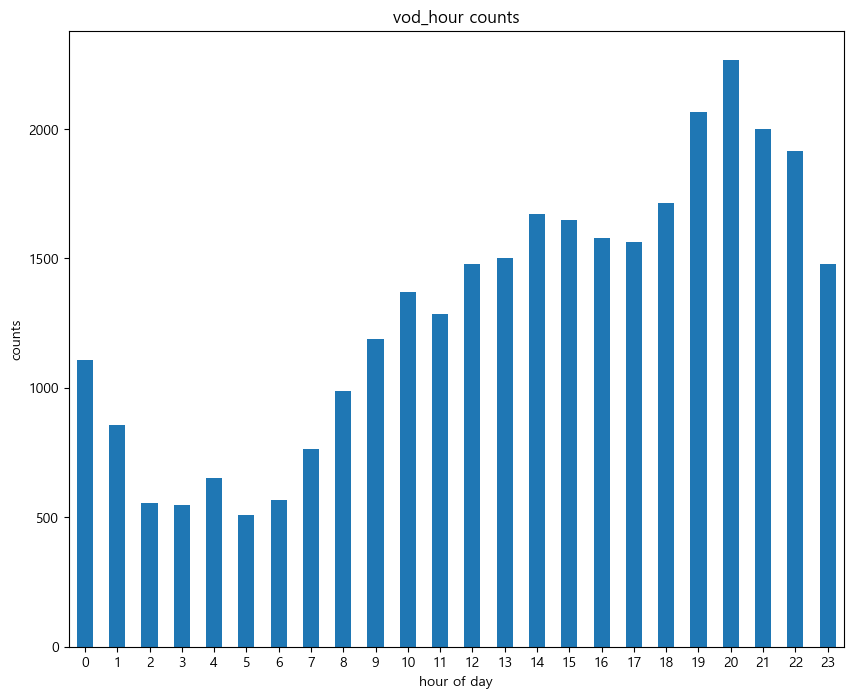

In [87]:
hour_counts = total['hour'].value_counts().sort_index()

plt.figure(figsize=(10,8))
hour_counts.plot(kind='bar')
plt.title('vod_hour counts')
plt.xlabel('hour of day')
plt.ylabel('counts')
plt.xticks(rotation=0)
plt.show()

In [88]:
# 시간대로만 만들어서 precisionk 확인
time_based_recommendation3 = []
# 시간 구간 낮일 때 
# 평일
total_day = total[(total['hour'] >= 8) & (total['hour'] <= 17)]
total_count = total_day['vod_id'].value_counts().sort_values(ascending=False)

for yesterday in [0,1]:
    for today in [0,1]:
        for tomorrow in [0,1]:
            for time in [1]:
                time_based_recommendation3.append([yesterday,today,tomorrow,time] + list(total_count.index[:10]))


# 시간 구간 새벽일 때 
total_dawn = total[(total['hour'] >= 0) & (total['hour'] <= 7)]
total_count = total_dawn['vod_id'].value_counts().sort_values(ascending=False)

for yesterday in [0,1]:
    for today in [0,1]:
        for tomorrow in [0,1]:
            for time in [0]:
                time_based_recommendation3.append([yesterday,today,tomorrow,time] + list(total_count.index[:10]))

    
# 시간구간 저녁일 때
total_night = total[(total['hour'] >= 18) & (total['hour'] <= 23)]
total_count = total_night['vod_id'].value_counts().sort_values(ascending=False)

for yesterday in [0,1]:
    for today in [0,1]:
        for tomorrow in [0,1]:
            for time in [2]:
                time_based_recommendation3.append([yesterday,today,tomorrow,time] + list(total_count.index[:10]))

In [89]:
# column 이름
columns = ['yesterday_type', 'today_type', 'tomorrow_type', 'time'] + [f'vod{i}' for i in range(1, 11)]
time_based_result3 = pd.DataFrame(time_based_recommendation3, columns=columns)
time_based_result3

,yesterday_type,today_type,tomorrow_type,time,vod1,vod2,vod3,vod4,vod5,vod6,vod7,vod8,vod9,vod10
0,0,0,0,1,296,1166,1156,8,2537,16,143,754,249,2865
1,0,0,1,1,296,1166,1156,8,2537,16,143,754,249,2865
2,0,1,0,1,296,1166,1156,8,2537,16,143,754,249,2865
3,0,1,1,1,296,1166,1156,8,2537,16,143,754,249,2865
4,1,0,0,1,296,1166,1156,8,2537,16,143,754,249,2865
5,1,0,1,1,296,1166,1156,8,2537,16,143,754,249,2865
6,1,1,0,1,296,1166,1156,8,2537,16,143,754,249,2865
7,1,1,1,1,296,1166,1156,8,2537,16,143,754,249,2865
8,0,0,0,0,754,738,1166,888,143,296,8,908,747,2537
9,0,0,1,0,754,738,1166,888,143,296,8,908,747,2537


In [90]:
precision_k(vod_10_true_df, time_based_result3, K = 10)

0.21666666666666667